# 0. Imports and Manual Inputs

### 0.1 Libraries imports

In [2]:
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
warnings.filterwarnings("ignore")

from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
from scipy.stats import linregress

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import zscore

# Times font for plotting
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# Background color on plot
plt.rcParams['axes.facecolor'] = 'snow'

# Data-display
from IPython.display import HTML
def horizontal(dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 32px">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

### 0.2 Data import

##### 0.2.1 Init connection to MySQL

In [86]:
connection = pymysql.connect(host='mysql-1.cda.hhs.se', port=int(3306), user='be903', passwd='robots',db='GbgHousingMarket')

##### 0.2.2 FULL data extraction (for processing)

In [87]:
# Apartments
apartments_query = f"""
SELECT *
FROM Apartment
"""
apartments_df = pd.read_sql_query(apartments_query, connection)

# AnnualReport
annualReport_query = f"""
SELECT *
FROM AnnualReport
"""
annualReport_df = pd.read_sql_query(annualReport_query, connection)

# Housing Association
housingAssociation_query = f"""
SELECT *
FROM HousingAssociation
"""
housingAssociation_df = pd.read_sql_query(housingAssociation_query, connection)

### 0.3 Set up of JSON environment

In [167]:
# Function to initialize the JSON file if it doesn't exist
def initialize_json_file(file_path):
    if not os.path.exists(file_path):
        with open(file_path, 'w') as f:
            json.dump([], f, indent=4)  # Create an empty list in the JSON file
        print(f"Initialized empty JSON file at {file_path}")
    else:
        print(f"JSON file already exists at {file_path}")

# Function to read the current content of the JSON file
def read_json_file(file_path):
    try:
        with open(file_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error reading JSON file {e}. Initializing a new empty file.")
        initialize_json_file(file_path)
        return []

# Function to write data back to the JSON file
def write_json_file(file_path, data):
    try:
        with open(file_path, 'w') as f:
            json.dump(data, f, indent=4)
    except Exception as e:
        print(f"Error writing to file: {e}")

# Function to append a new patient record with only patient_id
def append_record(file_path, id):
    # Read the current data
    data = read_json_file(file_path)
    
    # Check if the id already exists
    for record in data:
        if record['id'] == id:
            print(f"ID {id} already exists. Use the update function to modify this record.")
            return
    
    # Create a new record with only patient_id (other fields set to None)
    new_record = {
        "id": id,
        "predicted_sell_price": 'NULL'
    }

    data.append(new_record)              # Append the new record
    write_json_file(file_path, data)     # Write back to the file

# Function to update a specific field for an existing patient record
def update_field(file_path, id, field_name, field_value):
    # Validate field_name
    valid_fields = ["predicted_sell_price"]

    if field_name not in valid_fields:
        print(f"Error: Invalid field name '{field_name}'. Must be one of {valid_fields}.")
        return
    
    data = read_json_file(file_path)
    
    for record in data:
        if record["id"] == id:
            record[field_name] = field_value
            write_json_file(file_path, data)
            return
    
    print(f" ID {id} not found. Use the append function to add a new record.")

##### 0.3.1 Init JSON file

In [89]:
# Define the path to the JSON file
JSON_FILE_PATH = '25770_assignment3.json'

initialize_json_file(JSON_FILE_PATH)

# Print the content of the JSON file
print("\nContent of the JSON file:")
with open(JSON_FILE_PATH, 'r') as f:
    print(json.dumps(json.load(f), indent=4))

JSON file already exists at 25770_assignment3.json

Content of the JSON file:
[]


# 1. Data Processing

### 1.1 Completeness

This test directly filters out which potential features that contains enough data to be useful. We can directly disregard potential featues with a completeness less than, say 30 %. Energy class is the only potential feature which we may have to look further into to see if its worth using.

In [90]:
apartment_completeness = round((1 - apartments_df.isnull().sum(axis=0) / apartments_df.shape[0]) * 100, 2).to_frame().rename(columns={0 : 'Completenss [%]'})
annualReport_completeness = round((1 - annualReport_df.isnull().sum(axis=0) / annualReport_df.shape[0]) * 100, 2).to_frame().rename(columns={0 : 'Completenss [%]'})
housingAssociation_completeness = round((1 - housingAssociation_df.isnull().sum(axis=0) / housingAssociation_df.shape[0]) * 100, 2).to_frame().rename(columns={0 : 'Completenss [%]'})

horizontal([apartment_completeness, annualReport_completeness, housingAssociation_completeness])

,Completenss [%]
id,100.00
additional_area,0.90
agency_id,99.74
amenities,100.00
asking_price,51.64
brokers_description,100.00
cover_photo_description,2.02
customer_area_description,79.96
district,100.00
energy_class,39.27


### 1.2 Uniqueness

We double check that none of the df's contain duplicates of their primary key (column that makes each row unique).

In [91]:
# Primary keys
apartments_primary_key = ['id']
annualReport_primary_key = ['org_number', 'fiscal_year']
housingAssociation_primary_key = ['org_number']

apartment_uniqueness = (apartments_df[apartments_primary_key].drop_duplicates().shape[0] / apartments_df.shape[0]) * 100
annualReport_uniqueness = (annualReport_df[annualReport_primary_key].drop_duplicates().shape[0] / annualReport_df.shape[0]) * 100
housingAssociation_uniqueness = (housingAssociation_df[housingAssociation_primary_key].drop_duplicates().shape[0] / housingAssociation_df.shape[0]) * 100

print(f"""
Uniqueness [%] of Apartment df: {apartment_uniqueness}

Uniqueness [%] of AnnualReport df: {annualReport_uniqueness}

Uniqueness [%] of housingAssociation df: {housingAssociation_uniqueness}
""")


Uniqueness [%] of Apartment df: 100.0

Uniqueness [%] of AnnualReport df: 100.0

Uniqueness [%] of housingAssociation df: 100.0



### 1.3 Data disctribution

##### 1.3.1 Convert all columns to numerical

In [92]:
def numerical_conversion(df, categorical_cols):
    for col in categorical_cols:
        le = LabelEncoder()
        all_categories = df[col].astype(str).unique()
        le.fit(all_categories)
        df[col] = le.transform(df[col].astype(str))
    
    return df


In [93]:
categorical_a = ['amenities', 'brokers_description', 'cover_photo_description',
                 'customer_area_description', 'district', 'energy_class', 'heating',
                 'key', 'locality', 'location', 'municipality', 'populated_area', 
                 'primary_area', 'region', 'sell_date', 'street_address'
                ]
apartments_df_numerical = apartments_df.copy()
apartments_df_numerical = numerical_conversion(apartments_df_numerical, categorical_a).drop(columns=apartments_primary_key)

categorical_ar = ['association_tax_liability']
annualReport_df_numerical = annualReport_df.copy()
annualReport_df_numerical = numerical_conversion(annualReport_df_numerical, categorical_ar).drop(columns=annualReport_primary_key)

categorical_h = ['name']
housingAssociation_df_numerical = housingAssociation_df.copy()
housingAssociation_df_numerical = numerical_conversion(housingAssociation_df_numerical, categorical_h).drop(columns=housingAssociation_primary_key)

##### 1.3.2 Plot data distributions for Apartments data

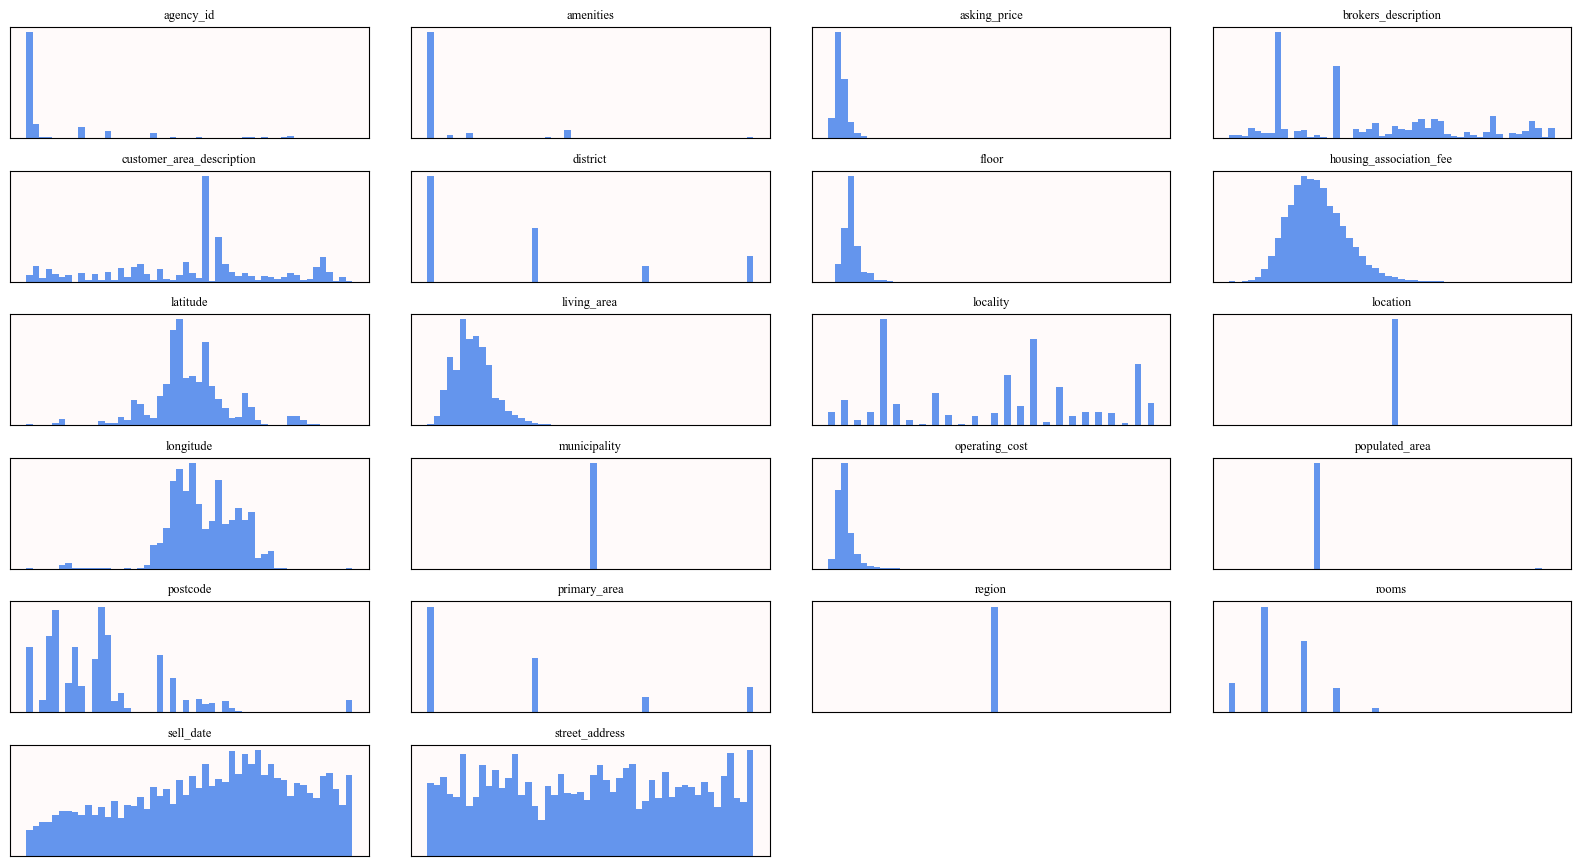

In [94]:
apartments_exclude = ['additional_area', 'energy_class', 'cover_photo_description', 'has_balcony', 'has_fireplace', 'has_patio', 'has_solar_panels', 'heating', 'height', 'is_new_construction', 'key', 'plot_area', 'width']
used_columns = list(apartments_df_numerical.columns)
[used_columns.remove(item) for item in apartments_exclude]
used_columns.remove('housing_association_org_number')

n = len(used_columns)

colors = ['cornflowerblue', 'slateblue']
fig, axes = plt.subplots(nrows=int(np.ceil(n / 4)), ncols=4, figsize=(16,9))

axes = axes.ravel()

for i,col in enumerate(used_columns):
    if col in apartments_exclude:
        pass
    else:
        axes[i].hist(apartments_df_numerical[col].dropna(), bins=50, color='cornflowerblue')
        axes[i].set_title(f'{col}', fontsize=9)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.tight_layout()
#fig.delaxes(axes[-3])
fig.delaxes(axes[-2])
fig.delaxes(axes[-1])
plt.show()

##### 1.3.3 Plot data distributions for Annual report data

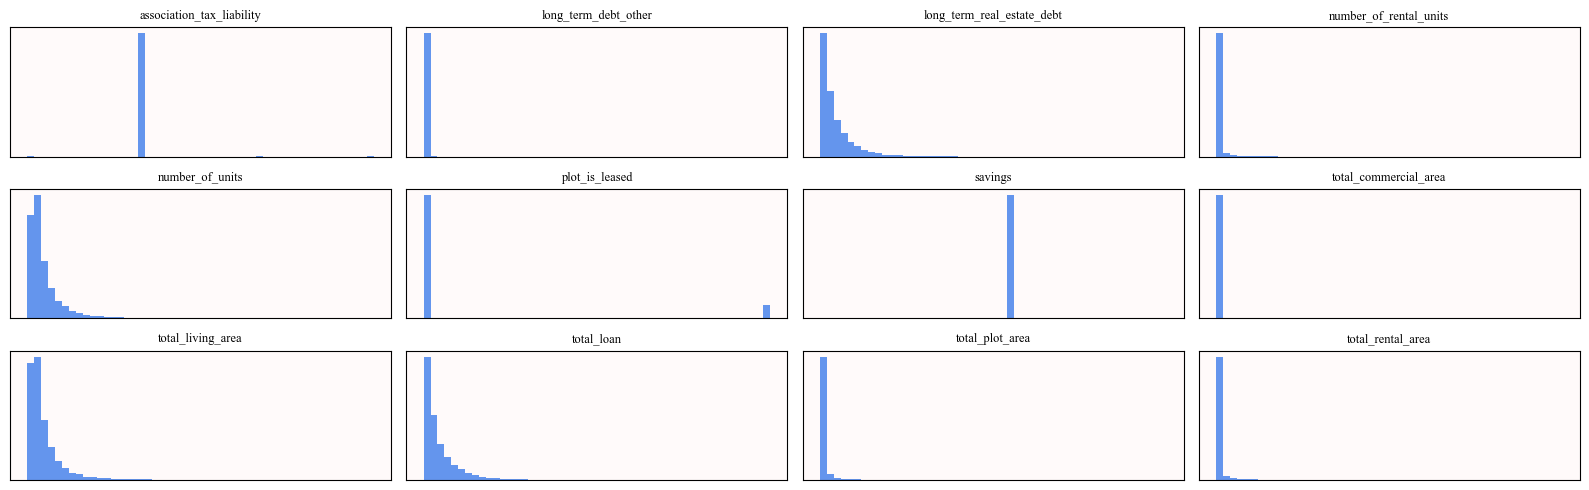

In [95]:
n = annualReport_df_numerical.shape[1]

colors = ['cornflowerblue', 'slateblue']
fig, axes = plt.subplots(nrows=int(np.ceil(n / 4)), ncols=4, figsize=(16,5))

axes = axes.ravel()

for i,col in enumerate(annualReport_df_numerical.columns):
    axes[i].hist(annualReport_df_numerical[col].dropna(), bins=50, color='cornflowerblue')
    axes[i].set_title(f'{col}', fontsize=9)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

##### 1.3.3 Plot data distributions for Housing Association data

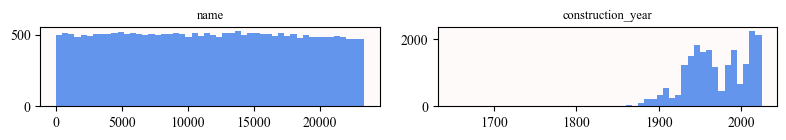

In [96]:
n = housingAssociation_df_numerical.shape[1]

colors = ['cornflowerblue', 'slateblue']
fig, axes = plt.subplots(nrows=int(np.ceil(n / 4)), ncols=4, figsize=(16,1.5))

axes = axes.ravel()

for i,col in enumerate(housingAssociation_df_numerical.columns):
    axes[i].hist(housingAssociation_df_numerical[col].dropna(), bins=50, color='cornflowerblue')
    axes[i].set_title(f'{col}', fontsize=9)

plt.tight_layout()
fig.delaxes(axes[-2])
fig.delaxes(axes[-1])
plt.show()

### 1.4 Annual Report data

##### 1.4.1 Number of annual reports per organisation number

In [97]:
years_per_org = annualReport_df.groupby('org_number')['fiscal_year'].nunique()
print("Number of years per org_number:\n", years_per_org.describe())

Number of years per org_number:
 count    25002.000000
mean         3.327974
std          1.501178
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          7.000000
Name: fiscal_year, dtype: float64


##### 1.4.2 Annual Report trends

In [98]:
# Function to calculate trend (slope) over years
def calculate_trend(group, column):
    if len(group) < 2:  # Need at least 2 years for a trend
        return np.nan
    years = group['fiscal_year'].astype(int)
    values = group[column]
    slope, _, _, _, _ = linregress(years, values)
    return slope

In [99]:
# Apply log transformation to numerical features

annualReport_df['log_long_term_real_estate_debt'] = np.log1p(annualReport_df['long_term_real_estate_debt'])
annualReport_df['log_total_loan'] = np.log1p(annualReport_df['total_loan'])
annualReport_df['log_number_of_units'] = np.log1p(annualReport_df['number_of_units'])
annualReport_df['log_total_living_area'] = np.log1p(annualReport_df['total_living_area'])

In [100]:
# Sort by fiscal_year to ensure chronological order for trend calculation
annualReport_df = annualReport_df.sort_values(['org_number', 'fiscal_year'])

# Aggregate financial data for each org_number
annualReport_agg = annualReport_df.groupby('org_number').agg({
    'log_long_term_real_estate_debt': [
        ('mean_debt', 'mean'),
        ('std_debt', 'std'),
        ('max_debt', 'max'),
        ('min_debt', 'min')
    ],
    'log_total_loan': [
        ('mean_loan', 'mean'),
        ('std_loan', 'std'),
        ('max_loan', 'max'),
        ('min_loan', 'min')
    ],
    'log_number_of_units': [
        ('mean_units', 'mean'),
        ('std_units', 'std')
    ],
    'log_total_living_area': [
        ('mean_total_area', 'mean'),
        ('std_total_area', 'std')
    ]
}).reset_index()

# Flatten column names after aggregation
annualReport_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in annualReport_agg.columns]

# Calculate trends for key columns
trends = annualReport_df.groupby('org_number').apply(
    lambda group: pd.Series({
        'debt_trend': calculate_trend(group, 'log_long_term_real_estate_debt'),
        'loan_trend': calculate_trend(group, 'log_total_loan')
    })
).reset_index()

# Merge trends with aggregated data
annualReport_agg = annualReport_agg.merge(trends, on='org_number', how='left')
annualReport_agg.head()

,org_number,log_long_term_real_estate_debt_mean_debt,log_long_term_real_estate_debt_std_debt,log_long_term_real_estate_debt_max_debt,log_long_term_real_estate_debt_min_debt,log_total_loan_mean_loan,log_total_loan_std_loan,log_total_loan_max_loan,log_total_loan_min_loan,log_number_of_units_mean_units,log_number_of_units_std_units,log_total_living_area_mean_total_area,log_total_living_area_std_total_area,debt_trend,loan_trend
0,556024-1415,14.525712,NaN,14.525712,14.525712,14.525712,NaN,14.525712,14.525712,2.772589,NaN,7.469084,NaN,NaN,NaN
1,702000-0035,14.059618,NaN,14.059618,14.059618,14.059618,NaN,14.059618,14.059618,3.044522,NaN,7.439559,NaN,NaN,NaN
2,702000-0282,16.454383,0.603274,16.853104,15.569049,16.454383,0.603274,16.853104,15.569049,3.960768,0.010997,8.236685,0.0,0.278395,0.278395
3,702000-0399,16.409730,0.042614,16.475422,16.380077,16.409730,0.042614,16.475422,16.380077,3.761200,0.000000,7.991254,0.0,0.008768,0.008768
4,702000-0407,14.599666,0.010577,14.607145,14.592187,14.599666,0.010577,14.607145,14.592187,2.397895,0.000000,6.587550,0.0,-0.014958,-0.014958


In [101]:
# Check for NaN values in trends
print("Missing values in trends:\n", annualReport_agg[['debt_trend', 'loan_trend']].isnull().mean())

Missing values in trends:
 debt_trend    0.160227
loan_trend    0.160267
dtype: float64


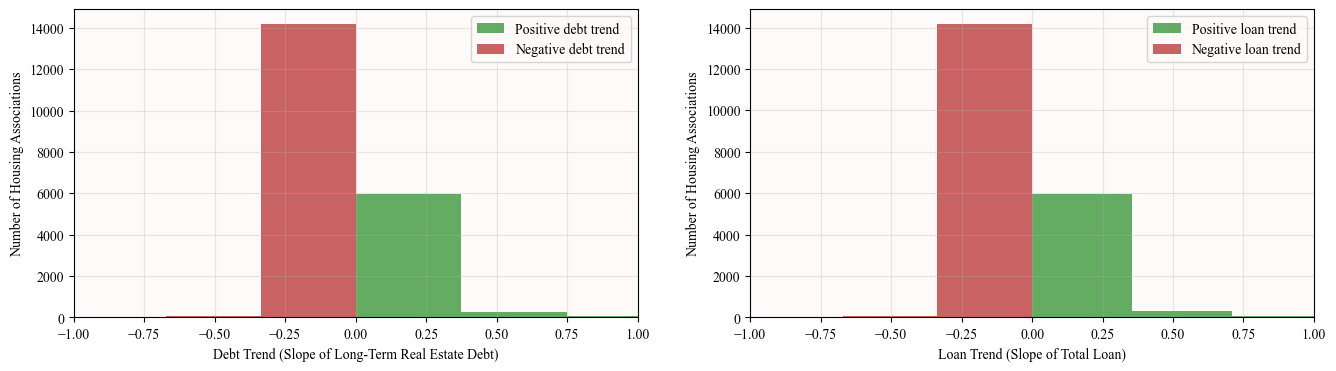

In [102]:
# Drop NaN values for plotting (we'll analyze only org_numbers with valid trends)
trends_data = annualReport_agg[['debt_trend', 'loan_trend']].dropna()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

axes = axes.ravel()

axes[0].hist(trends_data[trends_data['debt_trend'] >= 0]['debt_trend'], bins=50, color='forestgreen', alpha=0.7, label='Positive debt trend')
axes[0].hist(trends_data[trends_data['debt_trend'] < 0]['debt_trend'], bins=50, color='firebrick', alpha=0.7, label='Negative debt trend')
#axes[0].set_title('Distribution of Debt Trends', fontsize=12)
axes[0].set_xlabel('Debt Trend (Slope of Long-Term Real Estate Debt)', fontsize=10)
axes[0].set_ylabel('Number of Housing Associations', fontsize=10)
axes[0].set_xlim(xmin=-1, xmax=1)
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].hist(trends_data[trends_data['loan_trend'] >= 0]['loan_trend'], bins=50, color='forestgreen', alpha=0.7, label='Positive loan trend')
axes[1].hist(trends_data[trends_data['loan_trend'] < 0]['loan_trend'], bins=50, color='firebrick', alpha=0.7, label='Negative loan trend')
#axes[1].set_title('Distribution of Loan Trends', fontsize=12)
axes[1].set_xlabel('Loan Trend (Slope of Total Loan)', fontsize=10)
axes[1].set_ylabel('Number of Housing Associations', fontsize=10)
axes[1].set_xlim(xmin=-1, xmax=1)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

##### 1.4.3 Compute new ratios

In [103]:
# Debt per unit
annualReport_agg['debt_per_unit'] = annualReport_agg['log_long_term_real_estate_debt_mean_debt'] / annualReport_agg['log_number_of_units_mean_units']

# Loan growth rate (relative change over time)
annualReport_agg['loan_growth_rate'] = annualReport_agg['loan_trend'] / annualReport_agg['log_total_loan_mean_loan'].replace(0, np.nan)

# Financial stability (ratio of debt to total loan)
annualReport_agg['debt_to_loan_ratio'] = annualReport_agg['log_long_term_real_estate_debt_mean_debt'] / annualReport_agg['log_total_loan_mean_loan'].replace(0, np.nan)


### 1.5 Temporal trends in sell date (Apartment data)

In [104]:
date_df = apartments_df['sell_date'].to_frame()
date_df = pd.to_datetime(date_df['sell_date']).to_frame()

# Derive sell_year and sell_month features
apartments_df['sell_year'] = date_df['sell_date'].dt.year
apartments_df['sell_month'] = date_df['sell_date'].dt.month

##### 1.5.1 Visual inspection

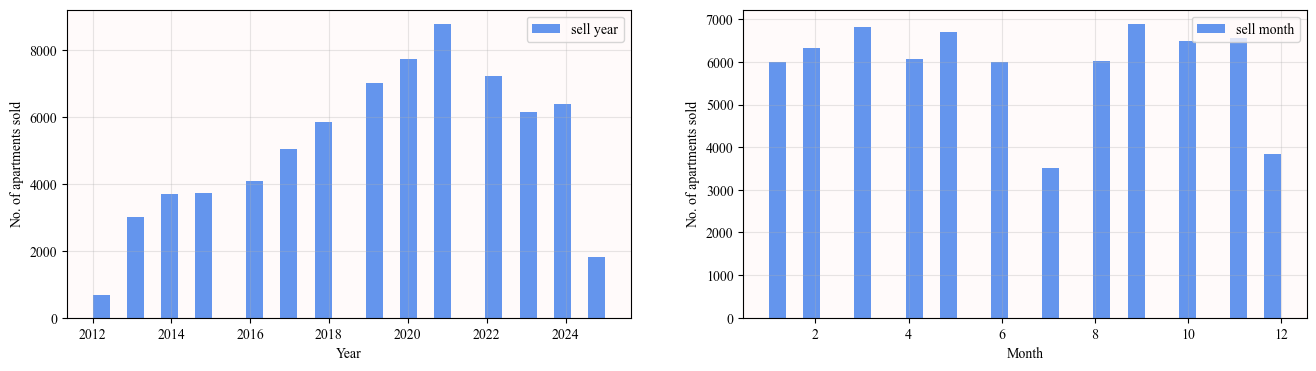

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

axes = axes.ravel()

axes[0].hist(apartments_df['sell_year'], bins=30, color='cornflowerblue', label='sell year')
axes[0].legend(loc='upper right')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('No. of apartments sold')
axes[0].grid(True, alpha=0.3)

axes[1].hist(apartments_df['sell_month'], bins=30, color='cornflowerblue', label = 'sell month')
axes[1].legend(loc='upper right')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('No. of apartments sold')
axes[1].grid(True, alpha=0.3)

plt.show()

### 1.6 Building age

In [106]:
housingAssociation_df['age'] = 2025 - housingAssociation_df['construction_year'] # current year - construction year = age
housingAssociation_df['age'] = housingAssociation_df['age']

# 2. Feature Engineering

### 2.1 Target Variable Analysis

In [107]:
target = 'sell_price' # belongs to apartment df

# Calculate statistics for reference lines
target_mean = apartments_df[target].mean()
percentile_5 = np.percentile(apartments_df[target].dropna(), 5)
percentile_95 = np.percentile(apartments_df[target].dropna(), 95)

##### 2.1.1 Visualise distribution

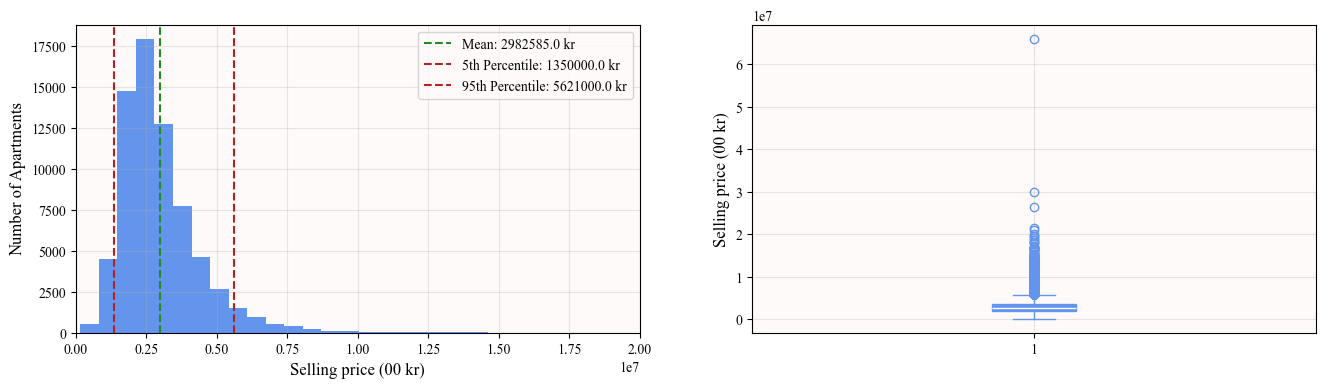

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

axes = axes.ravel()

axes[0].hist(apartments_df[target], bins=100, color='cornflowerblue')

# Add reference lines
axes[0].axvline(target_mean, color='forestgreen', linestyle='--', label=f'Mean: {np.round(target_mean,0):.1f} kr')
axes[0].axvline(percentile_5, color='firebrick', linestyle='--', label=f'5th Percentile: {np.round(percentile_5,0):.1f} kr')
axes[0].axvline(percentile_95, color='firebrick', linestyle='--', label=f'95th Percentile: {np.round(percentile_95,0):.1f} kr')

axes[0].set_xlim(xmin=0e7, xmax=2e7)
axes[0].set_xlabel('Selling price (00 kr)', fontsize=12)
axes[0].set_ylabel('Number of Apartments', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

boxplot = axes[1].boxplot(apartments_df[target].dropna(), 
                      patch_artist=True,
                      medianprops=dict(color='white'))

plt.setp(boxplot['boxes'], color='cornflowerblue')
plt.setp(boxplot['fliers'], markeredgecolor='cornflowerblue')
plt.setp(boxplot['whiskers'], color='cornflowerblue')
plt.setp(boxplot['caps'], color='cornflowerblue')
axes[1].set_ylabel('Selling price (00 kr)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.show()

##### 2.1.2 Summary Statistics

In [109]:
sell_price_stats = apartments_df[target].describe()
sell_price_stats.to_frame()

,sell_price
count,6.943700e+04
mean,2.982585e+06
std,1.483259e+06
min,1.500000e+05
25%,2.025000e+06
50%,2.650000e+06
75%,3.550000e+06
max,6.599500e+07


##### 2.1.3 Skewness correction

In [110]:
log_target = 'log_sell_price'
apartments_df[log_target] = np.log1p(apartments_df[target])

log_target_mean = apartments_df[log_target].mean()
log_percentile_5 = np.percentile(apartments_df[log_target].dropna(), 5)
log_percentile_95 = np.percentile(apartments_df[log_target].dropna(), 95)

log_sell_price_stats = apartments_df[log_target].describe()
log_sell_price_stats.to_frame()

,log_sell_price
count,69437.000000
mean,14.807698
std,0.444684
min,11.918397
25%,14.521081
50%,14.790071
75%,15.082458
max,18.005090


<Figure size 1000x600 with 0 Axes>

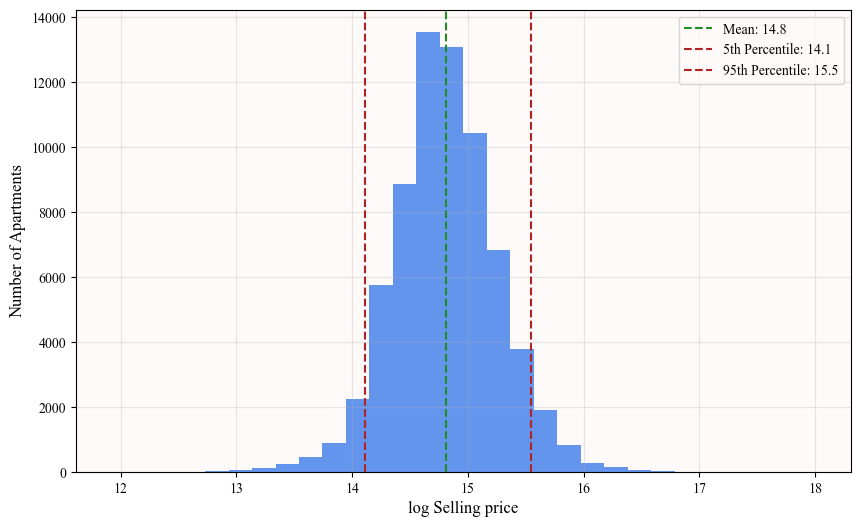

In [111]:
plt.figure(figsize=(10, 6))

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(apartments_df[log_target], bins=30, color='cornflowerblue')

# Add reference lines
plt.axvline(log_target_mean, color='forestgreen', linestyle='--', label=f'Mean: {log_target_mean:.1f}')
plt.axvline(log_percentile_5, color='firebrick', linestyle='--', label=f'5th Percentile: {log_percentile_5:.1f}')
plt.axvline(log_percentile_95, color='firebrick', linestyle='--', label=f'95th Percentile: {log_percentile_95:.1f}')

# Customize the plot
plt.xlabel('log Selling price', fontsize=12)
plt.ylabel('Number of Apartments', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2.2 Target-Feature analysis

After inital data processing, we have removed quite a few features due to a too low degree of completeness or an insufficient distribution.

In [112]:
# log-transformations
apartments_df['log_asking_price'] = np.log1p(apartments_df['asking_price'])
apartments_df['log_floor'] = np.log1p(apartments_df['floor'])
apartments_df['log_housing_association_fee'] = np.log1p(apartments_df['housing_association_fee'])
apartments_df['log_living_area'] = np.log1p(apartments_df['living_area'])
apartments_df['log_operating_cost'] = np.log1p(apartments_df['operating_cost'])

# numerical conversion
apartments_df = numerical_conversion(apartments_df, ['district', 'primary_area'])

In [113]:
# agent_id: Target Encoding
agent_price_mean = apartments_df.groupby('agency_id')[log_target].mean().to_dict()
apartments_df['agency_selling_price_mean'] = apartments_df['agency_id'].map(agent_price_mean)

# 2. amenities: Parse and Create Binary Features
# Amenities is a comma-separated string (e.g., "balcony, elevator")
# Identify top amenities (5)
apartments_df['amenities'] = apartments_df['amenities'].fillna('').str.lower()
all_amenities = apartments_df['amenities'].str.split(', ').explode()
top_amenities = all_amenities.value_counts().head(5).index.tolist()  # Top 5 amenities
for amenity in top_amenities:
    if amenity:  # Skip empty strings
        apartments_df[f'has_{amenity}'] = apartments_df['amenities'].apply(lambda x: 1 if amenity in x else 0)


# 2. amenities: Parse and Create Binary Features
# Amenities is a comma-separated string (e.g., "balcony, elevator")
# Identify top 30% amenities
apartments_df['amenities'] = apartments_df['amenities'].fillna('').str.lower()
all_amenities = apartments_df['amenities'].str.split(', ').explode()
top_amenities = all_amenities.value_counts().head(np.floor(all_amenities.nunique() * 0.3).astype(int)).index.tolist()  # Top 30% amenities
for amenity in top_amenities:
    if amenity:  # Skip empty strings
        apartments_df[f'has_{amenity}'] = apartments_df['amenities'].apply(lambda x: 1 if amenity in x else 0)


# 3. latitude, longitude: Clustering + Distance to City Center
# Remove any rows with missing lat/lon (if applicable)
apartments_df = apartments_df.dropna(subset=['latitude', 'longitude'])

# Distance to Gothenburg city center (approx coordinates: 57.7089, 11.9746)
city_center = (57.7089, 11.9746)
apartments_df['distance_to_center'] = apartments_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), city_center).km, axis=1
)

In [114]:
possible_features = ['agency_selling_price_mean', 'has_elevator', 'has_elevator,balcony', 'log_asking_price', 'district', 'log_floor', 'log_housing_association_fee', 
                     'distance_to_center', 'log_living_area', 'log_operating_cost', 'primary_area', 'rooms', 'sell_year', 'sell_month', 'age', 
                     'log_long_term_real_estate_debt_mean_debt', 'log_long_term_real_estate_debt_std_debt', 'log_total_loan_mean_loan', 'log_total_loan_std_loan', 
                     'log_number_of_units_mean_units', 'log_number_of_units_std_units', 'log_total_living_area_mean_total_area', 'debt_trend', 'loan_trend', 
                     'debt_per_unit', 'loan_growth_rate', 'debt_to_loan_ratio']

##### 2.2.1 Merge all 3 tables for easier handling

In [117]:
# Join with Apartment data
df_merged = apartments_df.merge(
    annualReport_agg,
    left_on='housing_association_org_number',
    right_on='org_number',
    how='left'
)

df_merged = df_merged.merge(housingAssociation_df[['org_number', 'construction_year', 'age']], left_on='housing_association_org_number', right_on='org_number', how='left')

# Drop redundant org_number columns
df_merged = df_merged.drop(columns=['org_number_x', 'org_number_y'])
df_merged = df_merged[['id'] + possible_features + [log_target]]
df_merged.head()

,id,agency_selling_price_mean,has_elevator,"has_elevator,balcony",log_asking_price,district,log_floor,log_housing_association_fee,distance_to_center,log_living_area,...,log_total_loan_std_loan,log_number_of_units_mean_units,log_number_of_units_std_units,log_total_living_area_mean_total_area,debt_trend,loan_trend,debt_per_unit,loan_growth_rate,debt_to_loan_ratio,log_sell_price
0,0002cdf8e99738f3bd1313b22f0a5eb7,14.927266,0,0,15.360943,0,0.693147,8.091321,0.642908,4.276666,...,0.252152,4.584967,0.000000,9.013959,0.113346,0.113346,3.831199,0.006453,1.0,15.360943
1,00033bd28c9a2a71f4baa3bd90f75000,14.755063,0,0,15.024471,0,1.791759,8.166500,2.130268,4.127134,...,0.196896,5.479804,0.001867,9.628452,0.052902,0.052902,3.247624,0.002973,1.0,15.139930
2,0006f0be006cecc61717cca039c954e3,14.927266,0,0,15.189226,0,1.386294,8.753529,2.070172,4.317488,...,0.703393,2.944439,0.000000,7.131699,0.486987,0.486987,5.329524,0.031033,1.0,15.199302
3,00079c16c41da46ac7ae95a422fd7881,14.911328,0,0,14.580979,1,0.693147,8.284504,2.302411,4.204693,...,0.051993,5.940171,0.000000,10.056756,-0.026820,-0.026820,3.091379,-0.001461,1.0,14.723770
4,0007e1bb59762644a698e6b64269433e,14.986303,0,0,NaN,0,1.098612,8.107419,4.173803,3.806662,...,0.157337,4.197174,0.008682,8.330251,0.076371,0.076371,3.909395,0.004654,1.0,14.751604


In [119]:
df_merged.to_csv('full_data_processed.csv') # write to csv
df_merged = df_merged[possible_features + [log_target]]
df_merged.head()

,agency_selling_price_mean,has_elevator,"has_elevator,balcony",log_asking_price,district,log_floor,log_housing_association_fee,distance_to_center,log_living_area,log_operating_cost,...,log_total_loan_std_loan,log_number_of_units_mean_units,log_number_of_units_std_units,log_total_living_area_mean_total_area,debt_trend,loan_trend,debt_per_unit,loan_growth_rate,debt_to_loan_ratio,log_sell_price
0,14.927266,0,0,15.360943,0,0.693147,8.091321,0.642908,4.276666,5.707110,...,0.252152,4.584967,0.000000,9.013959,0.113346,0.113346,3.831199,0.006453,1.0,15.360943
1,14.755063,0,0,15.024471,0,1.791759,8.166500,2.130268,4.127134,5.908083,...,0.196896,5.479804,0.001867,9.628452,0.052902,0.052902,3.247624,0.002973,1.0,15.139930
2,14.927266,0,0,15.189226,0,1.386294,8.753529,2.070172,4.317488,5.996452,...,0.703393,2.944439,0.000000,7.131699,0.486987,0.486987,5.329524,0.031033,1.0,15.199302
3,14.911328,0,0,14.580979,1,0.693147,8.284504,2.302411,4.204693,6.021023,...,0.051993,5.940171,0.000000,10.056756,-0.026820,-0.026820,3.091379,-0.001461,1.0,14.723770
4,14.986303,0,0,NaN,0,1.098612,8.107419,4.173803,3.806662,5.908083,...,0.157337,4.197174,0.008682,8.330251,0.076371,0.076371,3.909395,0.004654,1.0,14.751604


##### 2.2.2 Visualise Target - Feature relationships

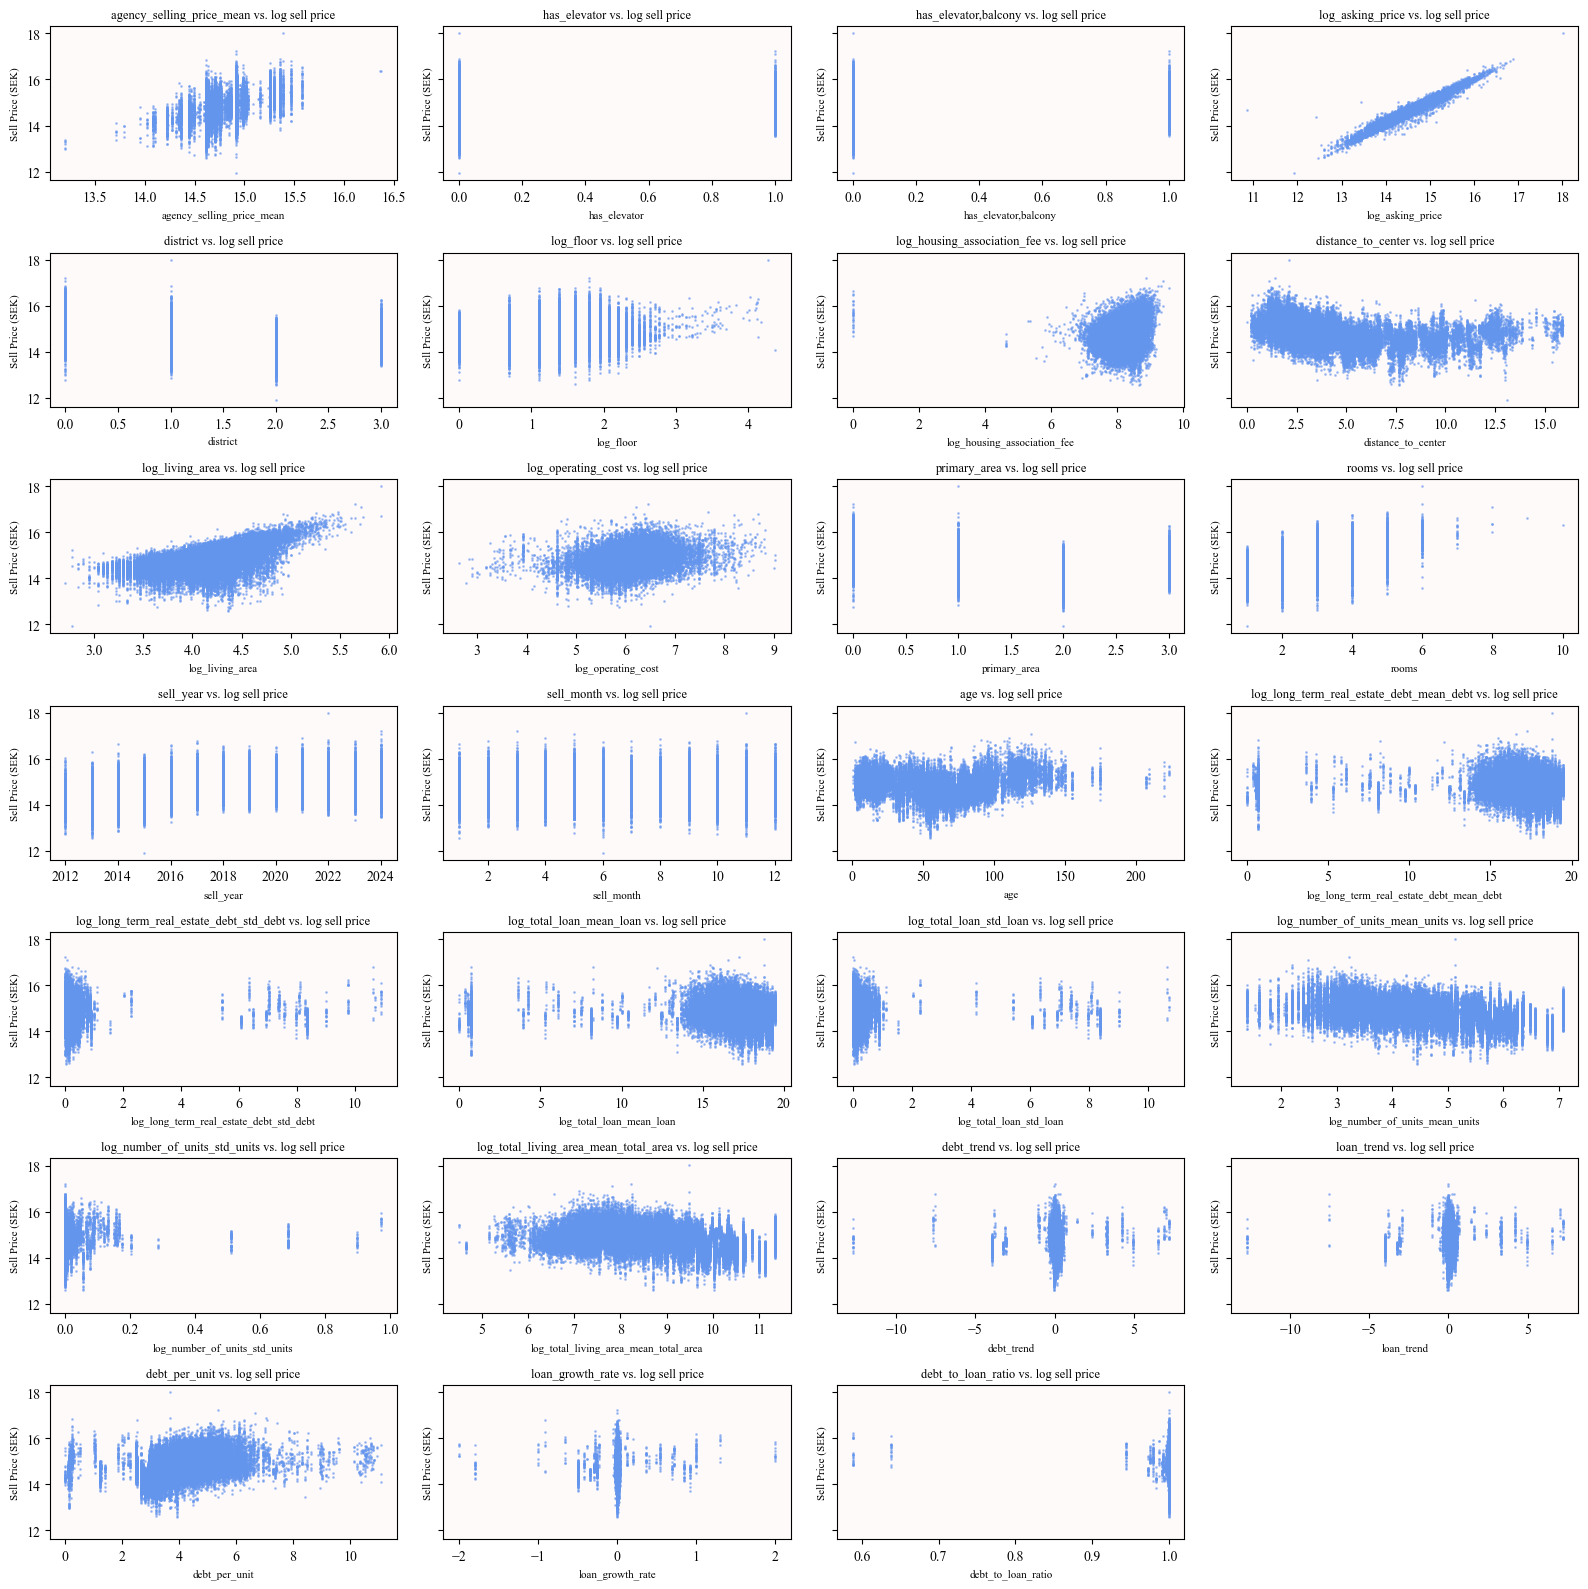

In [120]:
n = len(possible_features)
fig, axes = plt.subplots(nrows=int(np.ceil(n / 4)), ncols=4, figsize=(16, 16), sharey=True)
axes = axes.ravel()

for i, feature in enumerate(possible_features):
    x = pd.to_numeric(df_merged[feature], errors='coerce')
    y = df_merged[log_target]
    
    axes[i].scatter(x, y, color='cornflowerblue', alpha=0.5, s=1)
    axes[i].set_title(f'{feature} vs. log sell price', fontsize=9)
    axes[i].set_xlabel(feature, fontsize=8)
    axes[i].set_ylabel('Sell Price (SEK)', fontsize=8)

#fig.delaxes(axes[-3])
#fig.delaxes(axes[-2])
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

##### 2.2.3 Correlations

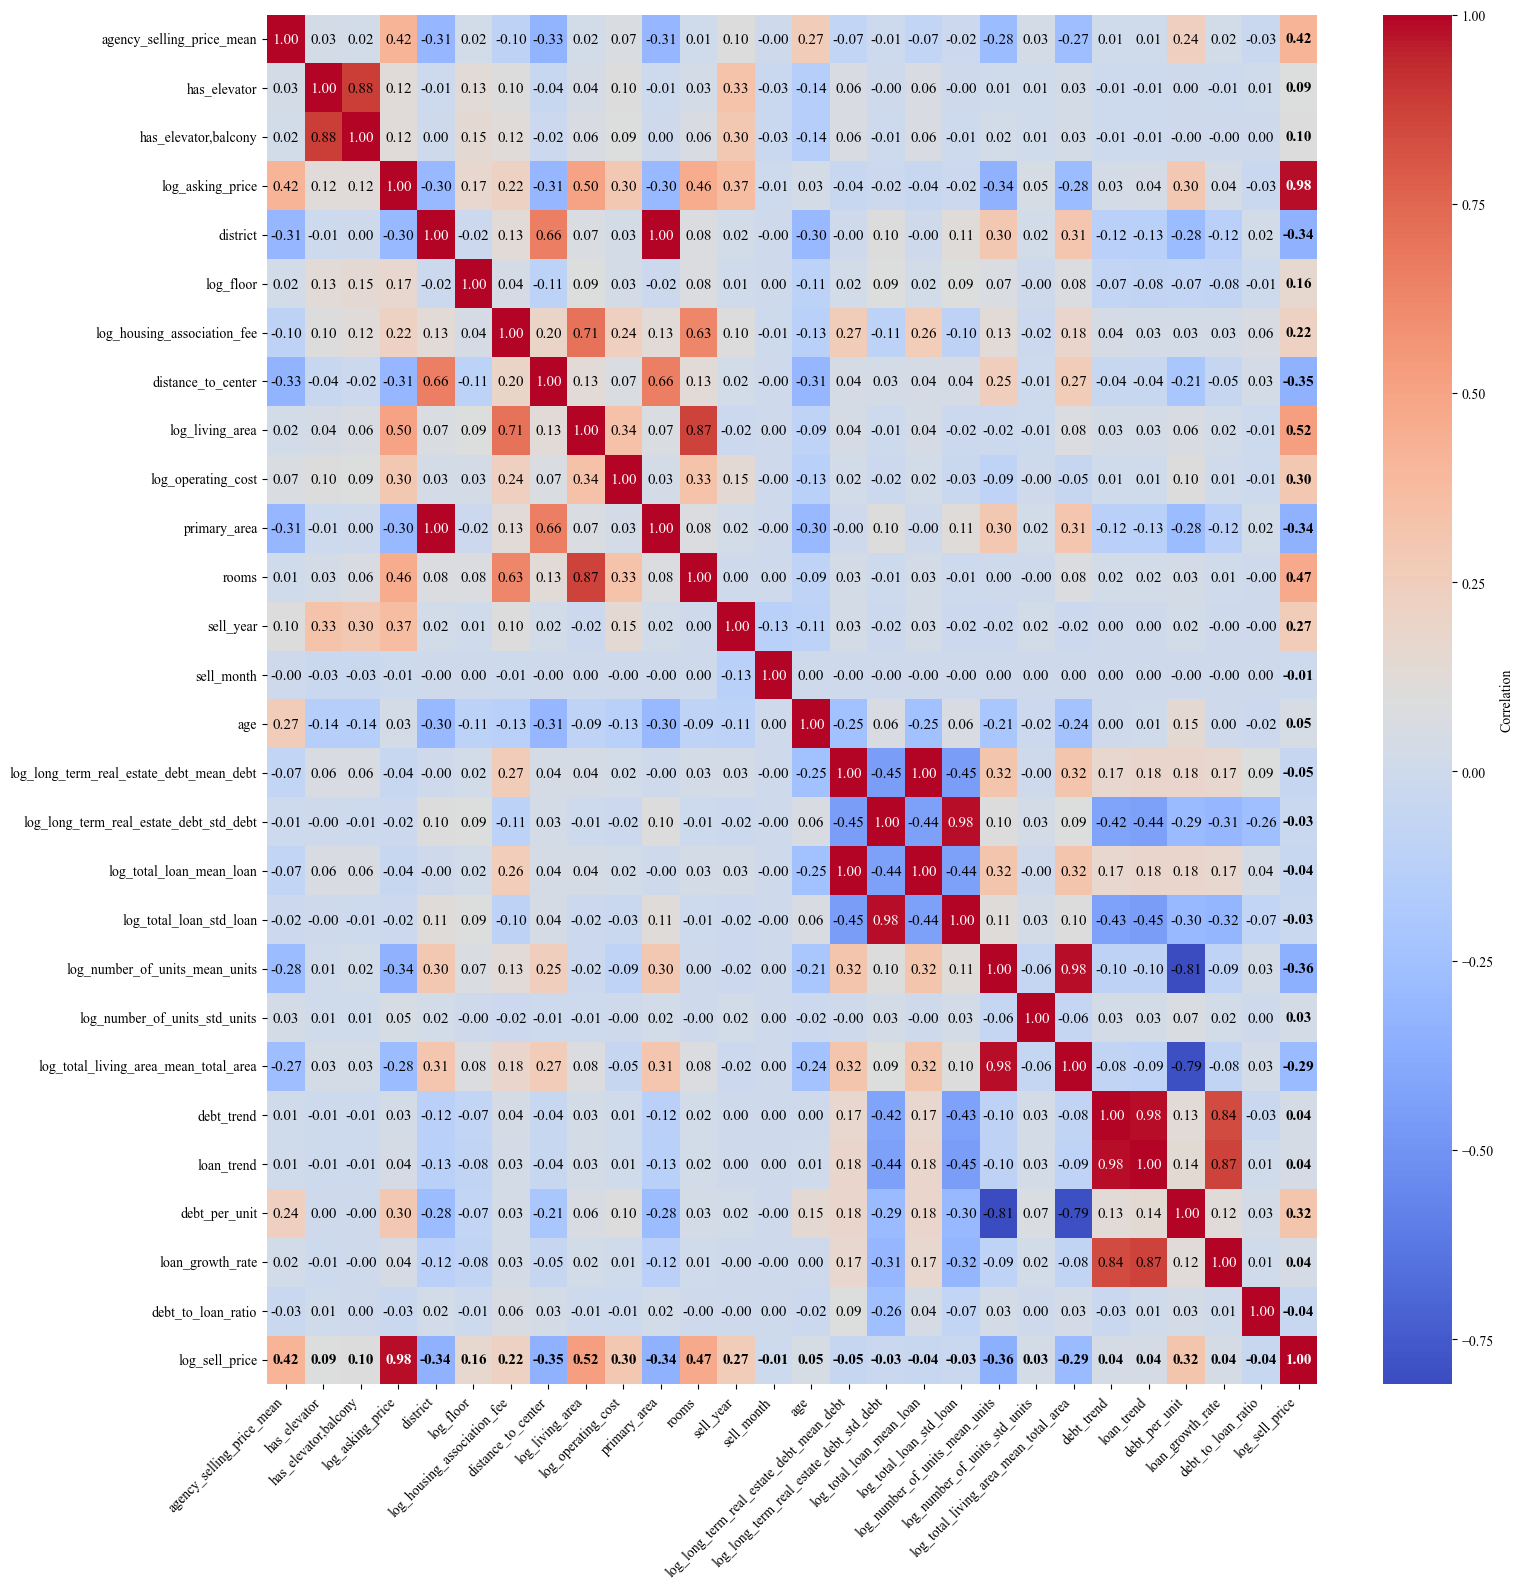

In [121]:
# Create the figure and heatmap
plt.figure(figsize=(16, 16))
corr = np.round(df_merged.corr(), 2)

ax = sns.heatmap(corr, cmap="coolwarm", annot=False, cbar_kws={'label': 'Correlation'})

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.iloc[i, j]
        # Highlight the target variable row/column in bold
        fontweight = 'bold' if (corr.index[i] == log_target or corr.columns[j] == log_target) else 'normal'
        # Adjust text color based on background (light or dark cell)
        # If the cell value is closer to 1 or -1 (red/blue), use white; otherwise, use black
        text_color = 'white' if abs(val) > 0.9 else 'black'

        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha="center", va="center", color=text_color, fontsize=11, fontweight=fontweight)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)


plt.tight_layout()
plt.show()

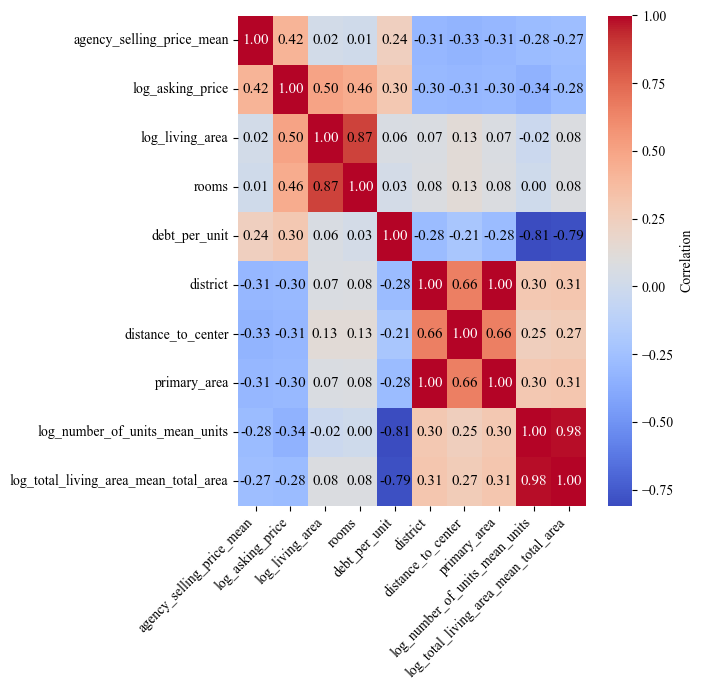

In [122]:
pos_corr = ['agency_selling_price_mean', 'log_asking_price', 'log_living_area', 'rooms', 'debt_per_unit']
neg_corr = ['district', 'distance_to_center', 'primary_area', 'log_number_of_units_mean_units', 'log_total_living_area_mean_total_area']

# Create the figure and heatmap
plt.figure(figsize=(7, 7))
corr = np.round(df_merged[pos_corr + neg_corr].corr(), 2)

ax = sns.heatmap(corr, cmap="coolwarm", annot=False, cbar_kws={'label': 'Correlation'})

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.iloc[i, j]
        # Highlight the target variable row/column in bold
        fontweight = 'bold' if (corr.index[i] == log_target or corr.columns[j] == log_target) else 'normal'
        # Adjust text color based on background (light or dark cell)
        # If the cell value is closer to 1 or -1 (red/blue), use white; otherwise, use black
        text_color = 'white' if abs(val) > 0.9 else 'black'
        if abs(val) < 0.3:
            cell_color = 'green' 

        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha="center", va="center", color=text_color, fontsize=11, fontweight=fontweight)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)


plt.tight_layout()
plt.show()

# 3. Model Desing and Tuning

### 3.1 Split data into train, test, and prediction set

In [124]:
df = pd.read_csv('full_data_processed.csv')
possible_features = ['agency_selling_price_mean', 'has_elevator', 'has_elevator,balcony', 'log_asking_price', 'district', 'log_floor', 'log_housing_association_fee', 
                     'distance_to_center', 'log_living_area', 'log_operating_cost', 'primary_area', 'rooms', 'sell_year', 'sell_month', 'age', 
                     'log_long_term_real_estate_debt_mean_debt', 'log_long_term_real_estate_debt_std_debt', 'log_total_loan_mean_loan', 'log_total_loan_std_loan', 
                     'log_number_of_units_mean_units', 'log_number_of_units_std_units', 'log_total_living_area_mean_total_area', 'debt_trend', 'loan_trend', 
                     'debt_per_unit', 'loan_growth_rate', 'debt_to_loan_ratio']
log_target = 'log_sell_price'
df = df[possible_features + [log_target]]

log_features = ['log_asking_price', 'log_floor', 'log_housing_association_fee', 'log_living_area', 'log_operating_cost', 
                'log_long_term_real_estate_debt_mean_debt', 'log_long_term_real_estate_debt_std_debt', 'log_total_loan_mean_loan',
                'log_total_loan_std_loan', 'log_number_of_units_mean_units','log_number_of_units_std_units', 'log_total_living_area_mean_total_area']

# Replace -inf with the minimum non-inf value minus 1
for feature in log_features:
    # Compute the minimum non-inf value for the feature in complete_data
    min_non_inf = df[feature][~np.isinf(df[feature])].min()
    replacement_value = min_non_inf - 1 if not np.isnan(min_non_inf) else 0
    # Replace -inf in both complete_data and prediction_set
    df[feature] = df[feature].replace(-np.inf, replacement_value)

prediction_df = df.loc[df[log_target].isna()] # target NA values
df = df.loc[~df[log_target].isin(prediction_df[log_target])] # remove missing values from main df

# Split the complete data into training and test sets
X = df.drop(columns=[log_target])
y = df[log_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

all_features = X.columns.unique()
# Compute imputation values on the training set only (to avoid leakage)
medians = X_train[all_features].median()

# Impute numerical features
X_train[all_features] = X_train[all_features].fillna(medians)
X_test[all_features] = X_test[all_features].fillna(medians)
prediction_df[all_features] = prediction_df[all_features].fillna(medians)



### 3.2 Feature selection

##### 3.2.1 Filter step - filter out the columns with low correlation to the target

In [36]:
# Filter features with low correlation to log_sell_price (|r| < 0.05)
train_df = pd.concat([X_train, y_train], axis=1)

correlations = train_df.corr()[log_target].drop(log_target)
filtered_features = correlations[abs(correlations) >= 0.05].index.tolist()
print(f"""
      Features after correlation filter (|rho| >= 0.05) on training set: 
      {filtered_features}
      """)
print(f"""
      Dropped features (|r| < 0.05): 
      {set(all_features) - set(filtered_features)}
      """)


      Features after correlation filter (|rho| >= 0.05) on training set: 
      ['agency_selling_price_mean', 'has_elevator', 'has_elevator,balcony', 'log_asking_price', 'district', 'log_floor', 'log_housing_association_fee', 'distance_to_center', 'log_living_area', 'log_operating_cost', 'primary_area', 'rooms', 'sell_year', 'log_number_of_units_mean_units', 'log_total_living_area_mean_total_area', 'debt_per_unit']
      

      Dropped features (|r| < 0.05): 
      {'debt_to_loan_ratio', 'loan_trend', 'log_long_term_real_estate_debt_mean_debt', 'log_total_loan_std_loan', 'sell_month', 'log_long_term_real_estate_debt_std_debt', 'age', 'log_number_of_units_std_units', 'debt_trend', 'loan_growth_rate', 'log_total_loan_mean_loan'}
      


In [37]:
# Subset the training, test, and prediction sets with filtered features
X_train_filtered = X_train[filtered_features].reset_index(drop=True)
X_test_filtered = X_test[filtered_features].reset_index(drop=True)
X_pred_filtered = prediction_df[filtered_features].reset_index(drop=True)

##### 3.2.2 Embedding step - Random forest feature importance

In [39]:
# Random Forest feature importance on the training set
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_filtered, y_train)

# Compute feature importance
feature_importance = pd.DataFrame({
    'Feature': filtered_features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance from Random Forest (training set):\n", feature_importance)


Feature Importance from Random Forest (training set):
                                   Feature  Importance
3                        log_asking_price    0.427283
8                         log_living_area    0.254645
7                      distance_to_center    0.134838
12                              sell_year    0.042690
15                          debt_per_unit    0.034024
10                           primary_area    0.018595
4                                district    0.018117
6             log_housing_association_fee    0.014933
14  log_total_living_area_mean_total_area    0.014228
13         log_number_of_units_mean_units    0.010018
0               agency_selling_price_mean    0.009746
5                               log_floor    0.007205
9                      log_operating_cost    0.006489
11                                  rooms    0.006102
1                            has_elevator    0.000672
2                    has_elevator,balcony    0.000414


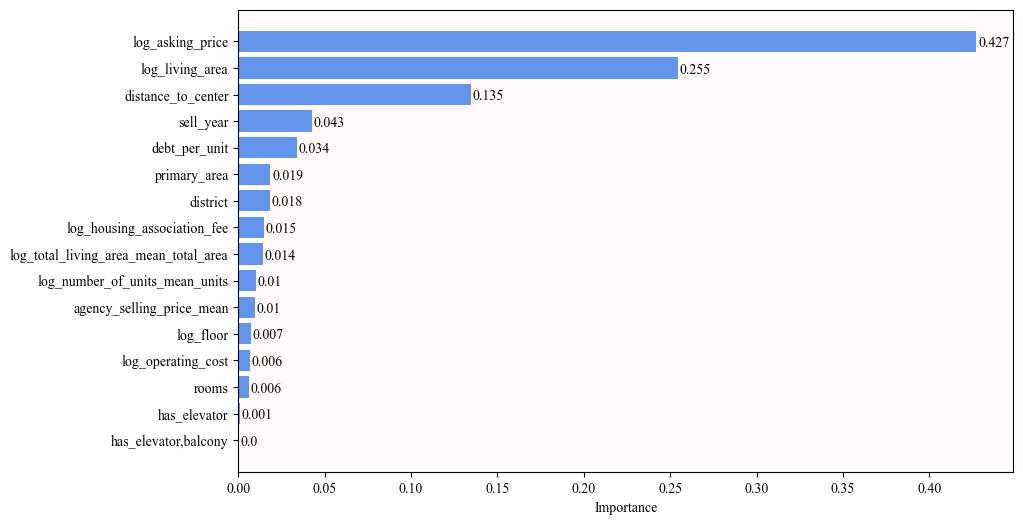

In [61]:
# Plot feature importance
fig, axes = plt.subplots(figsize=(10, 6))
axes.barh(feature_importance['Feature'],feature_importance['Importance'], color='cornflowerblue')
plt.xlabel('Importance')

for i, value in enumerate(feature_importance['Importance']):
    axes.text(value + 0.001, i + 0.2, str(np.round(value,3)))
#plt.title('Feature Importance from Random Forest (Training Set)')
plt.gca().invert_yaxis()
plt.show()

##### 3.2.3 Wrapper step - RFE

In [44]:
# 3.3: RFE
n_features_to_select = 5
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), 
          n_features_to_select=n_features_to_select)
rfe.fit(X_train_filtered, y_train)

rfe_selected_features = X_train_filtered.columns[rfe.support_].tolist()
print("Features selected by RFE:\n", rfe_selected_features)

Features selected by RFE:
 ['log_asking_price', 'distance_to_center', 'log_living_area', 'sell_year', 'debt_per_unit']


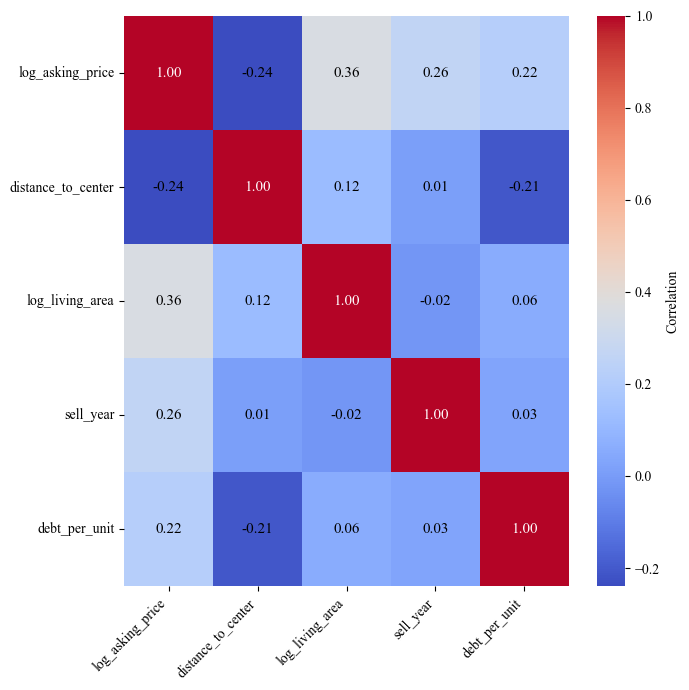

In [63]:
# Create the figure and heatmap
plt.figure(figsize=(7, 7))
corr = np.round(X_train_filtered[rfe_selected_features].corr(), 2)

ax = sns.heatmap(corr, cmap="coolwarm", annot=False, cbar_kws={'label': 'Correlation'})

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.iloc[i, j]
        # Highlight the target variable row/column in bold
        fontweight = 'bold' if (corr.index[i] == log_target or corr.columns[j] == log_target) else 'normal'
        # Adjust text color based on background (light or dark cell)
        # If the cell value is closer to 1 or -1 (red/blue), use white; otherwise, use black
        text_color = 'white' if abs(val) > 0.9 else 'black'
        if abs(val) < 0.3:
            cell_color = 'green' 

        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha="center", va="center", color=text_color, fontsize=11, fontweight=fontweight)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)


plt.tight_layout()
plt.show()

In [70]:
# Apply selected features to all sets
X_train_final = X_train[rfe_selected_features]
X_test_final = X_test[rfe_selected_features]
X_pred_final = prediction_df[rfe_selected_features]

y_train_final = y_train.to_frame()
y_test_final = y_test.to_frame()

X_train_final.to_parquet('X_train.parquet')
X_test_final.to_parquet('X_test.parquet')
X_pred_final.to_parquet('prediction_set.parquet')
y_train_final.to_parquet('y_train.parquet')
y_test_final.to_parquet('y_test.parquet')

### 3.3 Model Selection

In [17]:
log_target = 'log_sell_price'
X_train = pd.read_parquet('X_train.parquet')
y_train = pd.read_parquet('y_train.parquet')
X_test = pd.read_parquet('X_test.parquet')
y_test = pd.read_parquet('y_test.parquet')
prediction_set = pd.read_parquet('prediction_set.parquet')

features = ['log_asking_price', 'distance_to_center', 'log_living_area', 'sell_year', 'debt_per_unit']
# Dictionary to store model results
results = {}

##### 3.3.1 Baseline model - linear regression

In [3]:
# Baseline Model: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
test_rmse_lr_sell_price = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test_lr)))

results['Linear Regression'] = {
    'train_rmse': train_rmse_lr,
    'test_rmse': test_rmse_lr,
    'test_rmse_sell_price': test_rmse_lr_sell_price
}

##### 3.3.2 Primary model - Random forest regressor

In [4]:
# Primary model: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
test_rmse_rf_sell_price = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test_rf)))

results['Random Forest'] = {
    'train_rmse': train_rmse_rf,
    'test_rmse': test_rmse_rf,
    'test_rmse_sell_price': test_rmse_rf_sell_price
}

##### 3.3.3 Champion challenger - XGBoost regressor

In [5]:
# 3. Champion Challenger: XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)
y_pred_train_xgb = xgb.predict(X_train)
y_pred_test_xgb = xgb.predict(X_test)

train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
test_rmse_xgb_sell_price = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test_xgb)))

results['XGBoost'] = {
    'train_rmse': train_rmse_xgb,
    'test_rmse': test_rmse_xgb,
    'test_rmse_sell_price': test_rmse_xgb_sell_price
}

##### 3.3.4 Champion challenger - Neural network (MPLRgressor)

In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_pred_scaled = scaler.transform(prediction_set)

# Champion Challenger 2: Neural Network (MLPRegressor)
mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', 
                   alpha=0.0001, max_iter=500, early_stopping=True, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_train_mlp = mlp.predict(X_train_scaled)
y_pred_test_mlp = mlp.predict(X_test_scaled)

train_rmse_mlp = np.sqrt(mean_squared_error(y_train, y_pred_train_mlp))
test_rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_test_mlp))
test_rmse_mlp_sell_price = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test_mlp)))

results['Neural Network'] = {
    'train_rmse': train_rmse_mlp,
    'test_rmse': test_rmse_mlp,
    'test_rmse_sell_price': test_rmse_mlp_sell_price
}

##### 3.3.4 Results

In [8]:
# Print results
print("Model Performance Comparison:")
for model, metrics in results.items():
    print(f"\n{model}:")
    print(f"  Training RMSE (log_sell_price): {metrics['train_rmse']:.4f}")
    print(f"  Test RMSE (log_sell_price): {metrics['test_rmse']:.4f}")
    print(f"  Test RMSE (sell_price): {metrics['test_rmse_sell_price']:.2f}")

Model Performance Comparison:

Linear Regression:
  Training RMSE (log_sell_price): 0.2439
  Test RMSE (log_sell_price): 0.2455
  Test RMSE (sell_price): 836165.95

Random Forest:
  Training RMSE (log_sell_price): 0.0465
  Test RMSE (log_sell_price): 0.1200
  Test RMSE (sell_price): 434433.99

XGBoost:
  Training RMSE (log_sell_price): 0.1358
  Test RMSE (log_sell_price): 0.1436
  Test RMSE (sell_price): 497261.14

Neural Network:
  Training RMSE (log_sell_price): 0.1657
  Test RMSE (log_sell_price): 0.1707
  Test RMSE (sell_price): 558834.23


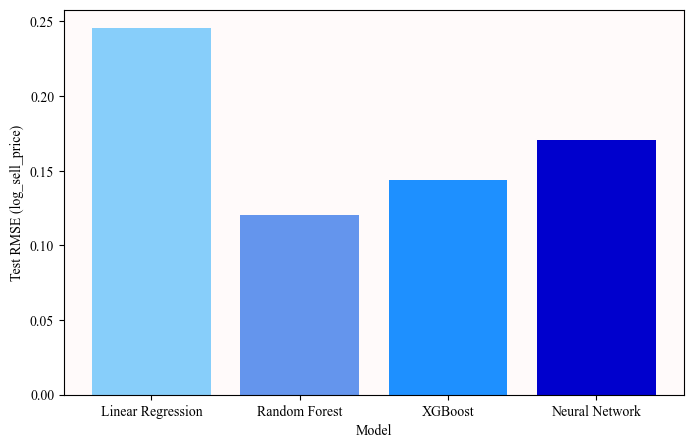

In [9]:
# Visualize test RMSE (log_sell_price)
models = list(results.keys())
test_rmse_values = [results[model]['test_rmse'] for model in models]

plt.figure(figsize=(8, 5))
plt.bar(models, test_rmse_values, color=['lightskyblue', 'cornflowerblue', 'dodgerblue', 'mediumblue'])
plt.xlabel('Model')
plt.ylabel('Test RMSE (log_sell_price)')
#plt.title('Model Comparison: Test RMSE')
plt.show()


In [10]:
# Choose the champion model (lowest test RMSE on log_sell_price)
champion_model_name = min(results, key=lambda x: results[x]['test_rmse'])
print(f"\nChampion Model: {champion_model_name} (Test RMSE: {results[champion_model_name]['test_rmse']:.4f})")


Champion Model: Random Forest (Test RMSE: 0.1200)


### 3.4 Tuning

In [2]:
log_target = 'log_sell_price'
X_train = pd.read_parquet('X_train.parquet')
y_train = pd.read_parquet('y_train.parquet')[log_target]
X_test = pd.read_parquet('X_test.parquet')
y_test = pd.read_parquet('y_test.parquet')[log_target]
prediction_set = pd.read_parquet('prediction_set.parquet')

##### 3.4.1 RandomizesSearchCV 

In [4]:
# Define a broader parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],           # More trees for better stability
    'max_depth': [10, 20, 30, 40, None],           # Wider range for tree depth
    'min_samples_split': [2, 5, 10, 20],           # More options to control splits
    'min_samples_leaf': [1, 2, 4, 8],              # More options for leaf size
    'max_features': ['sqrt', 'log2', 0.5, 0.8, 1.0],  # More feature sampling options
    'bootstrap': [True, False]                      # Test without bootstrap sampling
}

In [5]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to sample (increase if time allows)
    cv=5,       # 5-fold cross-validation for robust evaluation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all CPU cores
    verbose=2,  # Print progress
    random_state=42
)

In [7]:
# Fit Randomized Search on the training data
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.8min
[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.8min
[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.8min
[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.8min
[CV] END bootstrap=True, max_depth=30, max_features=0.8, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=  28.8s
[CV] END bootstrap=True, max_depth=30, max_features=0.8, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=  28.6s
[CV] END bootstrap=True, max_depth=30, max_features=0.8, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=  28.7s
[CV] END bootstrap=True, max_depth=30, m

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['sqrt', 'log2', 0.5,
                                                         0.8, 1.0],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

##### 3.4.2 Train and test on the best parameters

In [8]:
# Best parameters and score
best_params = random_search.best_params_
best_score = np.sqrt(-random_search.best_score_)  # Convert neg MSE to RMSE
print("\nBest Parameters (Randomized Search):", best_params)
print(f"Best Cross-Validation RMSE (log_sell_price): {best_score:.4f}")


Best Parameters (Randomized Search): {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30, 'bootstrap': False}
Best Cross-Validation RMSE (log_sell_price): 0.1194


In [9]:
# Train the best model on the full training set
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=0.5,
                      min_samples_leaf=2, min_samples_split=5, n_estimators=500,
                      random_state=42)

In [11]:
# Make predictions
y_pred_train_best = best_rf.predict(X_train)
y_pred_test_best = best_rf.predict(X_test)

# Compute RMSE for the tuned model
train_rmse_best = np.sqrt(mean_squared_error(y_train, y_pred_train_best))
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_test_best))
test_rmse_best_sell_price = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test_best)))

# Print results
print("\nAdvanced Tuned Random Forest Performance:")
print(f"  Training RMSE (log_sell_price): {train_rmse_best:.4f}")
print(f"  Test RMSE (log_sell_price): {test_rmse_best:.4f}")
print(f"  Test RMSE (sell_price): {test_rmse_best_sell_price:.2f}")


Advanced Tuned Random Forest Performance:
  Training RMSE (log_sell_price): 0.0506
  Test RMSE (log_sell_price): 0.1173
  Test RMSE (sell_price): 417938.66


##### 3.4.3 Exploring possible feature combinations

In [12]:
log_target = 'log_sell_price'
df = pd.read_csv('full_data_processed.csv')

log_features = ['log_asking_price', 'log_floor', 'log_housing_association_fee', 'log_living_area', 'log_operating_cost', 
                'log_long_term_real_estate_debt_mean_debt', 'log_long_term_real_estate_debt_std_debt', 'log_total_loan_mean_loan',
                'log_total_loan_std_loan', 'log_number_of_units_mean_units','log_number_of_units_std_units', 'log_total_living_area_mean_total_area']

# Replace -inf with the minimum non-inf value minus 1
for feature in log_features:
    # Compute the minimum non-inf value for the feature in complete_data
    min_non_inf = df[feature][~np.isinf(df[feature])].min()
    replacement_value = min_non_inf - 1 if not np.isnan(min_non_inf) else 0
    # Replace -inf in both complete_data and prediction_set
    df[feature] = df[feature].replace(-np.inf, replacement_value)

prediction_df = df.loc[df[log_target].isna()] # target NA values
df = df.loc[~df[log_target].isin(prediction_df[log_target])] # remove missing values from main df

# Split the complete data into training and test sets
X = df.drop(columns=[log_target])
y = df[log_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

all_features = X.columns.unique()
# Compute imputation values on the training set only (to avoid leakage)
medians = X_train[all_features].median()

# Impute numerical features
X_train[all_features] = X_train[all_features].fillna(medians)
X_test[all_features] = X_test[all_features].fillna(medians)
prediction_df[all_features] = prediction_df[all_features].fillna(medians)

In [19]:
# Define your tuned parameters
best_rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=30,  
    min_samples_split=5,
    min_samples_leaf=2,  
    max_features=0.5,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

In [20]:
# Fit model
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=0.5,
                      min_samples_leaf=2, min_samples_split=5, n_estimators=500,
                      n_jobs=-1, random_state=42)

In [22]:
# Make predictions
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# Compute RMSE for the tuned model
train_rmse_add = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_add = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_rmse_sell_price_add = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test)))

# Print results
print("\nAdvanced Tuned Random Forest Performance:")
print(f"  Training RMSE (log_sell_price): {train_rmse_add:.4f}")
print(f"  Test RMSE (log_sell_price): {test_rmse_add:.4f}")
print(f"  Test RMSE (sell_price): {test_rmse_sell_price_add:.2f}")


Advanced Tuned Random Forest Performance:
  Training RMSE (log_sell_price): 0.0237
  Test RMSE (log_sell_price): 0.0997
  Test RMSE (sell_price): 365940.11


##### 3.4.4 Model convergence

In [34]:
n=10
train_rmse_conv = []
test_rmse_conv = []
test_rmse_sell_price_conv = []

for i in range(n):

    # Define your tuned parameters
    best_rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=30,  
        min_samples_split=5,
        min_samples_leaf=2,  
        max_features=0.5,
        bootstrap=False,
        n_jobs=-1
    )

    # Fit model
    best_rf.fit(X_train, y_train)

    # Make predictions
    y_pred_train = best_rf.predict(X_train)
    y_pred_test = best_rf.predict(X_test)

    # Compute RMSE for the tuned model
    train_rmse_conv.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    test_rmse_conv.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    test_rmse_sell_price_conv.append(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test))))


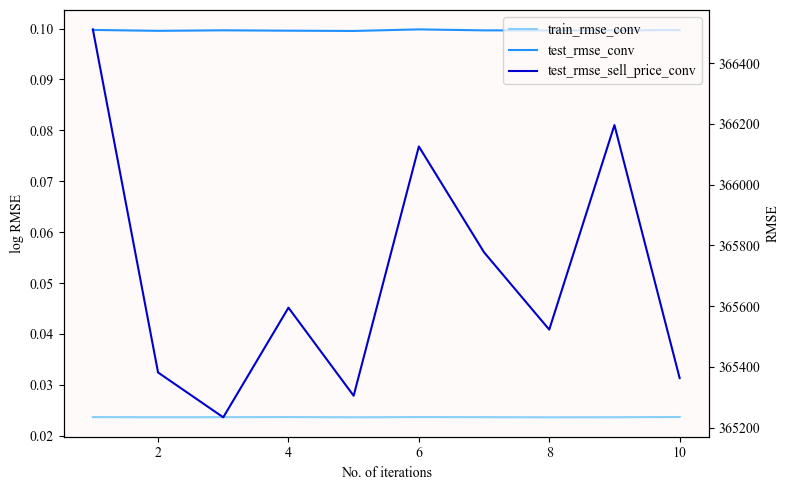

In [43]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

# Plot on ax1
line1, = ax1.plot(np.linspace(1,10,10), train_rmse_conv, color='lightskyblue', label='train_rmse_conv')
line2, = ax1.plot(np.linspace(1,10,10), test_rmse_conv, color='dodgerblue', label='test_rmse_conv')
ax1.set_xlabel('No. of iterations')
ax1.set_ylabel('log RMSE')

# Plot on ax2
line3, = ax2.plot(np.linspace(1,10,10), test_rmse_sell_price_conv, color='mediumblue', label='test_rmse_sell_price_conv')
ax2.set_ylabel('RMSE')

# Combine legends from both axes
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

# 4. Robustness

In [49]:
log_target = 'log_sell_price'
df = pd.read_csv('full_data_processed.csv')

log_features = ['log_asking_price', 'log_floor', 'log_housing_association_fee', 'log_living_area', 'log_operating_cost', 
                'log_long_term_real_estate_debt_mean_debt', 'log_long_term_real_estate_debt_std_debt', 'log_total_loan_mean_loan',
                'log_total_loan_std_loan', 'log_number_of_units_mean_units','log_number_of_units_std_units', 'log_total_living_area_mean_total_area']

# Replace -inf with the minimum non-inf value minus 1
for feature in log_features:
    # Compute the minimum non-inf value for the feature in complete_data
    min_non_inf = df[feature][~np.isinf(df[feature])].min()
    replacement_value = min_non_inf - 1 if not np.isnan(min_non_inf) else 0
    # Replace -inf in both complete_data and prediction_set
    df[feature] = df[feature].replace(-np.inf, replacement_value)

prediction_df = df.loc[df[log_target].isna()] # target NA values
df = df.loc[~df[log_target].isin(prediction_df[log_target])] # remove missing values from main df

### 4.1 Find outliers

In [51]:
# 1: Detect outliers 
# Z-score for each numeric column
features = ['agency_selling_price_mean', 'has_elevator', 'has_elevator,balcony', 'log_asking_price', 'district', 'log_floor',
            'log_housing_association_fee', 'distance_to_center', 'log_living_area', 'log_operating_cost', 'primary_area', 'rooms', 
            'sell_year', 'sell_month', 'age', 'log_long_term_real_estate_debt_mean_debt', 'log_long_term_real_estate_debt_std_debt', 
            'log_total_loan_mean_loan', 'log_total_loan_std_loan', 'log_number_of_units_mean_units', 'log_number_of_units_std_units',
            'log_total_living_area_mean_total_area', 'debt_trend', 'loan_trend', 'debt_per_unit', 'loan_growth_rate', 'debt_to_loan_ratio']

z_scores = np.abs(zscore(df[features + ['log_sell_price']]))
outlier_mask = (z_scores > 3).any(axis=1)

# Report how many outliers were found
print(f"Outliers found: {outlier_mask.sum()} out of {len(df)} rows")

Outliers found: 7146 out of 69437 rows


### 4.2 Compare model performance with and without outliers

In [53]:
df_clean = df[~outlier_mask]
df_outliers = df[outlier_mask]

# Split the complete data into training and test sets
X_clean = df_clean.drop(columns=[log_target])
y_clean = df_clean[log_target]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

all_features = X.columns.unique()

# Compute imputation values on the training set only (to avoid leakage)
medians_clean = Xc_train[all_features].median()

# Impute numerical features
Xc_train[all_features] = Xc_train[all_features].fillna(medians_clean)
Xc_test[all_features] = Xc_test[all_features].fillna(medians_clean)

In [55]:
# Define your tuned parameters
best_rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=30,  
    min_samples_split=5,
    min_samples_leaf=2,  
    max_features=0.5,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

# Fit model
best_rf.fit(Xc_train, yc_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=0.5,
                      min_samples_leaf=2, min_samples_split=5, n_estimators=500,
                      n_jobs=-1, random_state=42)

In [56]:
# Make predictions
yc_pred_train = best_rf.predict(Xc_train)
yc_pred_test = best_rf.predict(Xc_test)

# Compute RMSE for the tuned model
train_rmse_clean= np.sqrt(mean_squared_error(yc_train, yc_pred_train))
test_rmse_clean = np.sqrt(mean_squared_error(yc_test, yc_pred_test))
test_rmse_sell_price_clean = np.sqrt(mean_squared_error(np.exp(yc_test), np.exp(yc_pred_test)))

# Print results
print("\nAdvanced Tuned Random Forest Performance:")
print(f"  Training RMSE (log_sell_price): {train_rmse_clean:.4f}")
print(f"  Test RMSE (log_sell_price): {test_rmse_clean:.4f}")
print(f"  Test RMSE (sell_price): {test_rmse_sell_price_clean:.2f}")


Advanced Tuned Random Forest Performance:
  Training RMSE (log_sell_price): 0.0229
  Test RMSE (log_sell_price): 0.0945
  Test RMSE (sell_price): 321523.39


### 4.3 Simulate column loss

In [76]:
log_target = 'log_sell_price'
df = pd.read_csv('full_data_processed.csv')

log_features = ['log_asking_price', 'log_floor', 'log_housing_association_fee', 'log_living_area', 'log_operating_cost', 
                'log_long_term_real_estate_debt_mean_debt', 'log_long_term_real_estate_debt_std_debt', 'log_total_loan_mean_loan',
                'log_total_loan_std_loan', 'log_number_of_units_mean_units','log_number_of_units_std_units', 'log_total_living_area_mean_total_area']

# Replace -inf with the minimum non-inf value minus 1
for feature in log_features:
    # Compute the minimum non-inf value for the feature in complete_data
    min_non_inf = df[feature][~np.isinf(df[feature])].min()
    replacement_value = min_non_inf - 1 if not np.isnan(min_non_inf) else 0
    # Replace -inf in both complete_data and prediction_set
    df[feature] = df[feature].replace(-np.inf, replacement_value)

prediction_df = df.loc[df[log_target].isna()] # target NA values
df = df.loc[~df[log_target].isin(prediction_df[log_target])] # remove missing values from main df

# Split the complete data into training and test sets
X = df.drop(columns=[log_target])
y = df[log_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

all_features = X.columns.unique()
# Compute imputation values on the training set only (to avoid leakage)
medians = X_train[all_features].median()

# Impute numerical features
X_train[all_features] = X_train[all_features].fillna(medians)
X_test[all_features] = X_test[all_features].fillna(medians)
prediction_df[all_features] = prediction_df[all_features].fillna(medians)

In [77]:
def simulate_column_loss(X_df, column_name, strategy='zero'):
    X_corrupted = X_df.copy()
    if strategy == 'zero':
        X_corrupted[column_name] = 0
    return X_corrupted

In [79]:
rmse_base = 365940.11

print("\n Performance when columns are corrupted:")
for col in features:
    X_train_corrupted = simulate_column_loss(X_train, col, strategy='zero')  # Try 'null' instead if preferred
    X_test_corrupted = simulate_column_loss(X_test, col, strategy='zero')  # Try 'null' instead if preferred
    
    # Make predictions
    y_pred_train_corrupt = best_rf.predict(X_train_corrupted)
    y_pred_test_corrupt = best_rf.predict(X_test_corrupted)

    # Compute RMSE for the tuned model
    train_rmse_add = np.sqrt(mean_squared_error(y_train, y_pred_train_corrupt))
    test_rmse_corrupt = np.sqrt(mean_squared_error(y_test, y_pred_test_corrupt))
    test_rmse_sell_price_corrupt = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test_corrupt)))

    print(f"Column '{col}' corrupted → RMSE: {test_rmse_corrupt:.4f} (Δ {np.round(np.abs(test_rmse_sell_price_corrupt - rmse_base),2)})")


 Performance when columns are corrupted:
Column 'agency_selling_price_mean' corrupted → RMSE: 0.1572 (Δ 274933.91)
Column 'has_elevator' corrupted → RMSE: 0.1236 (Δ 180562.37)
Column 'has_elevator,balcony' corrupted → RMSE: 0.1236 (Δ 180562.37)
Column 'log_asking_price' corrupted → RMSE: 0.8501 (Δ 1782546.71)
Column 'district' corrupted → RMSE: 0.1534 (Δ 213314.15)
Column 'log_floor' corrupted → RMSE: 0.1321 (Δ 216396.39)
Column 'log_housing_association_fee' corrupted → RMSE: 0.1257 (Δ 170802.55)
Column 'distance_to_center' corrupted → RMSE: 0.1871 (Δ 279228.96)
Column 'log_living_area' corrupted → RMSE: 0.2916 (Δ 776921.0)
Column 'log_operating_cost' corrupted → RMSE: 0.1261 (Δ 187131.78)
Column 'primary_area' corrupted → RMSE: 0.1531 (Δ 212433.76)
Column 'rooms' corrupted → RMSE: 0.1552 (Δ 319563.14)
Column 'sell_year' corrupted → RMSE: 0.2882 (Δ 620402.63)
Column 'sell_month' corrupted → RMSE: 0.1252 (Δ 183037.88)
Column 'age' corrupted → RMSE: 0.1524 (Δ 223468.88)
Column 'log_long

# 5. Final predictions

### 5.1 Set up and predict

In [3]:
log_target = 'log_sell_price'
dff = pd.read_csv('full_data_processed.csv')
df = dff.copy()
possible_features = ['agency_selling_price_mean', 'has_elevator', 'has_elevator,balcony', 'log_asking_price', 'district', 'log_floor', 'log_housing_association_fee', 
                     'distance_to_center', 'log_living_area', 'log_operating_cost', 'primary_area', 'rooms', 'sell_year', 'sell_month', 'age', 
                     'log_long_term_real_estate_debt_mean_debt', 'log_long_term_real_estate_debt_std_debt', 'log_total_loan_mean_loan', 'log_total_loan_std_loan', 
                     'log_number_of_units_mean_units', 'log_number_of_units_std_units', 'log_total_living_area_mean_total_area', 'debt_trend', 'loan_trend', 
                     'debt_per_unit', 'loan_growth_rate', 'debt_to_loan_ratio']
log_target = 'log_sell_price'
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

df = df[possible_features + [log_target]]

log_features = ['log_asking_price', 'log_floor', 'log_housing_association_fee', 'log_living_area', 'log_operating_cost', 
                'log_long_term_real_estate_debt_mean_debt', 'log_long_term_real_estate_debt_std_debt', 'log_total_loan_mean_loan',
                'log_total_loan_std_loan', 'log_number_of_units_mean_units','log_number_of_units_std_units', 'log_total_living_area_mean_total_area']

# Replace -inf with the minimum non-inf value minus 1
for feature in log_features:
    # Compute the minimum non-inf value for the feature in complete_data
    min_non_inf = df[feature][~np.isinf(df[feature])].min()
    replacement_value = min_non_inf - 1 if not np.isnan(min_non_inf) else 0
    # Replace -inf in both complete_data and prediction_set
    df[feature] = df[feature].replace(-np.inf, replacement_value)

prediction_df = df.loc[df[log_target].isna()] # target NA values
df = df.loc[~df[log_target].isin(prediction_df[log_target])] # remove missing values from main df

# Split the complete data into training and test sets
X = df.drop(columns=[log_target])
prediction_df = prediction_df.drop(columns=[log_target])
y = df[log_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

all_features = X.columns.unique()
# Compute imputation values on the training set only (to avoid leakage)
medians = X_train[all_features].median()

# Impute numerical features
X_train[all_features] = X_train[all_features].fillna(medians)
X_test[all_features] = X_test[all_features].fillna(medians)
prediction_df[all_features] = prediction_df[all_features].fillna(medians)


In [4]:
# Define your tuned parameters
best_rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=30,  
    min_samples_split=5,
    min_samples_leaf=2,  
    max_features=0.5,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

# Fit model
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=0.5,
                      min_samples_leaf=2, min_samples_split=5, n_estimators=500,
                      n_jobs=-1, random_state=42)

In [159]:
# Make predictions
prediction_df['log_sell_price_predicted'] = best_rf.predict(prediction_df)

In [163]:
# Compute sell_price by exponentiating log_sell_price
prediction_df['sell_price_predicted'] = np.exp(prediction_df['log_sell_price_predicted'])

### 5.2 Feature importance

In [173]:
# Extract and display feature importance
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance in Random Forest Regressor:")
print(feature_importance)


Feature Importance in Random Forest Regressor:
                                     Feature  Importance
3                           log_asking_price    0.351375
8                            log_living_area    0.210241
7                         distance_to_center    0.105353
12                                 sell_year    0.052181
11                                     rooms    0.051885
4                                   district    0.043362
10                              primary_area    0.041888
14                                       age    0.035571
24                             debt_per_unit    0.022928
19            log_number_of_units_mean_units    0.013247
6                log_housing_association_fee    0.011773
21     log_total_living_area_mean_total_area    0.011187
0                  agency_selling_price_mean    0.008810
5                                  log_floor    0.005305
15  log_long_term_real_estate_debt_mean_debt    0.005303
17                  log_total_loan_mean_

### 5.3 Visualisation

In [164]:
final_predictions = dff.loc[dff[log_target].isna()]['id'].to_frame()
final_predictions['predicted_sell_price'] = prediction_df['sell_price_predicted']
final_predictions.head()

,id,predicted_sell_price
27,001eb0d02010d7cd3194bd0462b3d264,6.244994e+06
35,002dae21289c6940bd2bc1d9689a1d45,3.370546e+06
173,00a9be9cc9c23ad1d8088d38d3860c1d,6.374571e+06
195,00bc842ce93fbc9bf5b743e2bebff63a,2.945066e+06
241,00e7e1db9c33a0162e520953fc15ce13,1.822128e+06


In [170]:
# Calculate statistics for reference lines
pred_mean = final_predictions['predicted_sell_price'].mean()
percentile_5 = np.percentile(final_predictions['predicted_sell_price'].dropna(), 5)
percentile_95 = np.percentile(final_predictions['predicted_sell_price'].dropna(), 95)


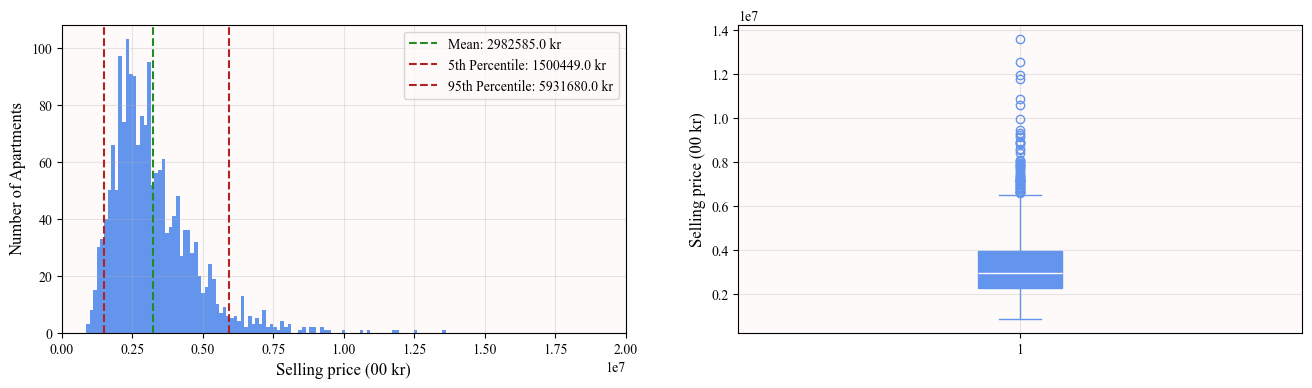

In [171]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

axes = axes.ravel()

axes[0].hist(final_predictions['predicted_sell_price'], bins=100, color='cornflowerblue')

# Add reference lines
axes[0].axvline(pred_mean, color='forestgreen', linestyle='--', label=f'Mean: {np.round(target_mean,0):.1f} kr')
axes[0].axvline(percentile_5, color='firebrick', linestyle='--', label=f'5th Percentile: {np.round(percentile_5,0):.1f} kr')
axes[0].axvline(percentile_95, color='firebrick', linestyle='--', label=f'95th Percentile: {np.round(percentile_95,0):.1f} kr')

axes[0].set_xlim(xmin=0e7, xmax=2e7)
axes[0].set_xlabel('Selling price (00 kr)', fontsize=12)
axes[0].set_ylabel('Number of Apartments', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

boxplot = axes[1].boxplot(final_predictions['predicted_sell_price'].dropna(), 
                      patch_artist=True,
                      medianprops=dict(color='white'))

plt.setp(boxplot['boxes'], color='cornflowerblue')
plt.setp(boxplot['fliers'], markeredgecolor='cornflowerblue')
plt.setp(boxplot['whiskers'], color='cornflowerblue')
plt.setp(boxplot['caps'], color='cornflowerblue')
axes[1].set_ylabel('Selling price (00 kr)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.show()

### 5.4 Write to JSON

In [165]:
for ID in final_predictions['id']:
    append_record(JSON_FILE_PATH, id=ID)

In [169]:
for index, row in final_predictions.iterrows():
    ID = row['id']
    value = int(row['predicted_sell_price']) # Asked to round any number to the nearest integer 
    update_field(JSON_FILE_PATH, id=ID, field_name='predicted_sell_price', field_value=value)

### 5.5 Cross-sectional analysis

In [11]:
# Function to compute RMSE for a subset
def compute_rmse(subset, target_col, pred_col):
    return np.sqrt(mean_squared_error(subset[target_col], subset[pred_col]))

In [71]:
# Make predictions
y_pred_test = best_rf.predict(X_test)

test_df = X_test.copy()
test_df['log_sell_price_predicted'] = y_pred_test
test_df['sell_price_predicted'] = np.exp(test_df['log_sell_price_predicted'])
test_df['log_sell_price'] = y_test
test_df['sell_price'] = np.exp(y_test)

# Case 1: Distance to Center (Close vs. Far)
test_df['distance_category'] = pd.cut(test_df['distance_to_center'],
                                      bins=[0, 2, 5, float('inf')],
                                      labels=['Close (<=2km)', 'Mid (2-5km)', 'Far (>5km)'],
                                      include_lowest=True)

# Case 2: Year of Sale (Older vs. Newer)
test_df['year_category'] = pd.cut(test_df['sell_year'],
                                  bins=[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
                                  labels=[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
                                  include_lowest=True)

# Case 3: Log Asking Price (Low, Mid, High)
asking_price_bins = pd.qcut(test_df['log_asking_price'], q=[0, 0.25, 0.75, 1.], labels=['Low', 'Mid', 'High'])
test_df['asking_price_category'] = asking_price_bins

In [72]:
# Analyze performance for each case
cases = [
    ('Distance to Center', 'distance_category'),
    ('Year of Sale', 'year_category'),
    ('Log Asking Price', 'asking_price_category')
]
df_result = pd.DataFrame(columns=['case', 'category', 'log RMSE', 'RMSE'])

print("\nModel Performance Across Cases (Random Forest):")
for case_name, case_col in cases:
    print(f"\nCase: {case_name}")
    for category in test_df[case_col].unique():
        if pd.isna(category):  # Skip NaN categories
            continue
        subset = test_df[test_df[case_col] == category]
        rmse_log = compute_rmse(subset, 'log_sell_price', 'log_sell_price_predicted')
        rmse_sek = compute_rmse(subset, 'sell_price', 'sell_price_predicted')

        res = pd.DataFrame({'case' : [case_name],
                            'category' : [category],
                            'log RMSE' : [rmse_log],
                            'RMSE' : [rmse_sek]
                            })
        
        df_result = pd.concat([df_result, res])

        print(f"  {category}:")
        print(f"    Number of samples: {len(subset)}")
        print(f"    RMSE (log_sell_price): {rmse_log:.4f}")
        print(f"    RMSE (sell_price): {rmse_sek:.2f} SEK")


Model Performance Across Cases (Random Forest):

Case: Distance to Center
  Mid (2-5km):
    Number of samples: 8269
    RMSE (log_sell_price): 0.0952
    RMSE (sell_price): 339173.18 SEK
  Close (<=2km):
    Number of samples: 2256
    RMSE (log_sell_price): 0.1035
    RMSE (sell_price): 543581.88 SEK
  Far (>5km):
    Number of samples: 3363
    RMSE (log_sell_price): 0.1059
    RMSE (sell_price): 261242.56 SEK

Case: Year of Sale
  2016:
    Number of samples: 813
    RMSE (log_sell_price): 0.1030
    RMSE (sell_price): 407925.55 SEK
  2020:
    Number of samples: 1541
    RMSE (log_sell_price): 0.0714
    RMSE (sell_price): 263396.47 SEK
  2023:
    Number of samples: 1269
    RMSE (log_sell_price): 0.1095
    RMSE (sell_price): 487346.26 SEK
  2017:
    Number of samples: 1012
    RMSE (log_sell_price): 0.0934
    RMSE (sell_price): 328312.12 SEK
  2024:
    Number of samples: 1302
    RMSE (log_sell_price): 0.1124
    RMSE (sell_price): 464761.53 SEK
  2015:
    Number of sample

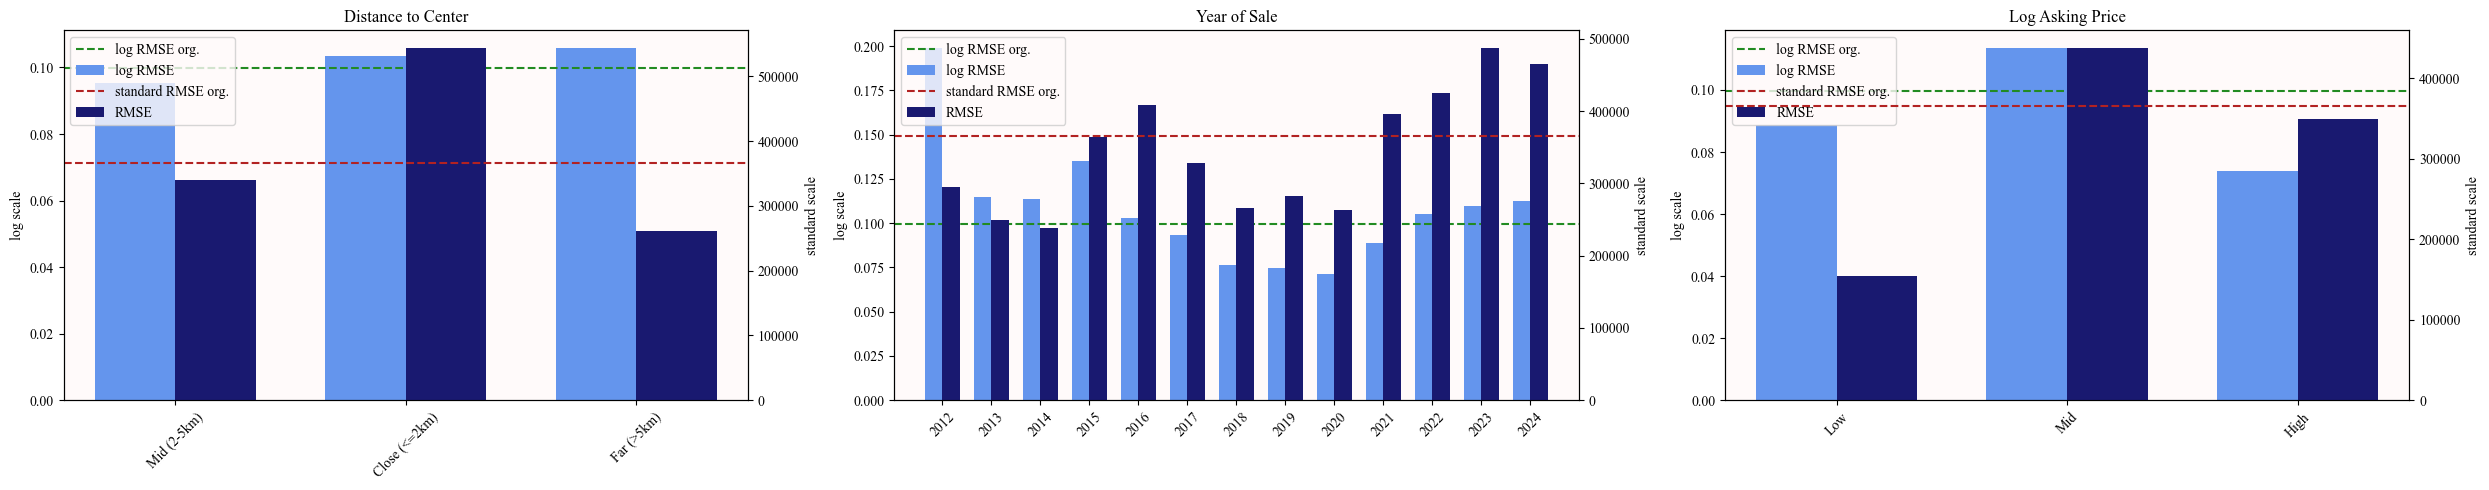

In [101]:
rmse_base = 365940.11
rmse_log_base = 0.0997

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
axes = axes.ravel()
width = 0.35  # Bar width

# --- First subplot: Distance to Center ---
df_sub1 = df_result[df_result['case'] == 'Distance to Center']
categories1 = df_sub1['category']
x1 = np.arange(len(categories1))

ax0 = axes[0]
ax0_2 = ax0.twinx()
bars1 = ax0.bar(x1 - width/2, df_sub1['log RMSE'], width=width, color='cornflowerblue', label='log RMSE')
bars2 = ax0_2.bar(x1 + width/2, df_sub1['RMSE'], width=width, color='midnightblue', label='RMSE')
hline1 = ax0.axhline(y=rmse_log_base, linestyle='--', color='forestgreen', label= 'log RMSE org.')
hline1_0 = ax0_2.axhline(y=rmse_base, linestyle='--', color='firebrick', label= 'standard RMSE org.')
ax0.set_ylabel('log scale')
ax0_2.set_ylabel('standard scale')
ax0.set_xticks(x1)
ax0.set_xticklabels(categories1, rotation=45)
ax0.set_title("Distance to Center")

# Combine legend from both axes
handles1, labels1 = ax0.get_legend_handles_labels()
handles2, labels2 = ax0_2.get_legend_handles_labels()
ax0.legend(handles1 + handles2, labels1 + labels2, loc='upper left')



# --- Second subplot: Year of Sale ---
df_sub2 = df_result[df_result['case'] == 'Year of Sale'].sort_values('category')
categories2 = df_sub2['category']
x2 = np.arange(len(categories2))

ax1 = axes[1]
ax1_2 = ax1.twinx()
hline2 = ax1.axhline(y=rmse_log_base, linestyle='--', color='forestgreen', label= 'log RMSE org.')
hline2_2 = ax1_2.axhline(y=rmse_base, linestyle='--', color='firebrick', label= 'standard RMSE org.')
bars3 = ax1.bar(x2 - width/2, df_sub2['log RMSE'], width=width, color='cornflowerblue', label='log RMSE')
bars4 = ax1_2.bar(x2 + width/2, df_sub2['RMSE'], width=width, color='midnightblue', label='RMSE')
ax1.set_ylabel('log scale')
ax1_2.set_ylabel('standard scale')
ax1.set_xticks(x2)
ax1.set_xticklabels(categories2, rotation=45)
ax1.set_title("Year of Sale")
handles3, labels3 = ax1.get_legend_handles_labels()
handles4, labels4 = ax1_2.get_legend_handles_labels()
ax1.legend(handles3 + handles4, labels3 + labels4, loc='upper left')

# --- Third subplot: Log Asking Price ---
df_sub3 = df_result[df_result['case'] == 'Log Asking Price']
categories3 = df_sub3['category']
x3 = np.arange(len(categories3))

ax2 = axes[2]
ax2_2 = ax2.twinx()
hline3 = ax2.axhline(y=rmse_log_base, linestyle='--', color='forestgreen', label= 'log RMSE org.')
hline3_2 = ax2_2.axhline(y=rmse_base, linestyle='--', color='firebrick', label= 'standard RMSE org.')
bars5 = ax2.bar(x3 - width/2, df_sub3['log RMSE'], width=width, color='cornflowerblue', label='log RMSE')
bars6 = ax2_2.bar(x3 + width/2, df_sub3['RMSE'], width=width, color='midnightblue', label='RMSE')
ax2.set_ylabel('log scale')
ax2_2.set_ylabel('standard scale')
ax2.set_xticks(x3)
ax2.set_xticklabels(categories3, rotation=45)
ax2.set_title("Log Asking Price")
handles5, labels5 = ax2.get_legend_handles_labels()
handles6, labels6 = ax2_2.get_legend_handles_labels()
ax2.legend(handles5 + handles6, labels5 + labels6, loc='upper left')

plt.tight_layout()
plt.show()
